In [58]:
#from cluster_g import *
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8807/2040397879.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [59]:
import torch
import pandas as pd
import numpy as np

# Load data
censor_df = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/censor_info.csv')
T = 52

# Convert to timepoints
max_timepoints = torch.tensor(
    (censor_df['max_censor'].values - 30).clip(0, T-1).astype(int)
)

# Only update censored cases (where E == T-1)
censored_mask = (E == T - 1)  # Shape: (N, D)

# For each patient, cap censored diseases to their max_timepoint
# Expand max_timepoints to match E shape
max_timepoints_expanded = max_timepoints.unsqueeze(1).expand_as(E)

# Update only censored positions
E_corrected = torch.where(
    censored_mask,
    torch.minimum(E, max_timepoints_expanded),
    E  # Keep event times as-is
)

# Save
torch.save(E_corrected, '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_matrix_corrected.pt')

In [60]:
E_corrected

tensor([[51, 51, 51,  ..., 51, 51, 51],
        [29, 29, 29,  ..., 29, 29, 29],
        [51, 51, 51,  ..., 51, 51, 51],
        ...,
        [30, 30, 30,  ..., 30, 30, 30],
        [40, 40, 40,  ..., 40, 40, 40],
        [41, 41, 41,  ..., 41, 23, 41]])

In [61]:
# Check that no event times were changed (only censored times)
original_events = (E < T - 1)
assert torch.all(E_corrected[original_events] == E[original_events]), "Event times changed!"

# Check that censored times are now capped correctly
print(f"Original max censored time: {E[E == T-1].max()}")
print(f"New max censored time: {E_corrected[E_corrected == T-1].max()}")

Original max censored time: 51
New max censored time: 51


EXAMPLES OF PEOPLE WITH EVENTS

Total patients with at least one event: 407,098 / 407,878

EXAMPLE PATIENTS WITH EVENTS

Patient 0:
  Number of diseases with events: 2
    Disease 161 (Asthma):
      E[0, 161] = 44 (age 74)
      Y[0, 161, :] has events at timepoints: [44]
      ✓ First event in Y matches E: True
    Disease 326 (Osteoarthrosis, localized, primary):
      E[0, 326] = 44 (age 74)
      Y[0, 326, :] has events at timepoints: [44]
      ✓ First event in Y matches E: True

Patient 1:
  Number of diseases with events: 2
    Disease 150 (Septal Deviations/Turbinate Hypertrophy):
      E[1, 150] = 22 (age 52)
      Y[1, 150, :] has events at timepoints: [22]
      ✓ First event in Y matches E: True
    Disease 157 (Other upper respiratory disease):
      E[1, 157] = 23 (age 53)
      Y[1, 157, :] has events at timepoints: [23]
      ✓ First event in Y matches E: True

Patient 2:
  Number of diseases with events: 3
    Disease 180 (GERD):
      E[2, 180] = 40 (age 70)
      Y[

EVENT DISTRIBUTION BY TIMEPOINT

Total events: 3,255,843

Events by timepoint (age):
Timepoint    Age      Count        Percent   
---------------------------------------------
0            30       731          0.02      %
1            31       1,217        0.04      %
2            32       2,204        0.07      %
3            33       2,527        0.08      %
4            34       4,274        0.13      %
5            35       4,422        0.14      %
6            36       6,222        0.19      %
7            37       6,409        0.20      %
8            38       8,899        0.27      %
9            39       8,867        0.27      %
10           40       12,905       0.40      %
11           41       12,548       0.39      %
12           42       17,793       0.55      %
13           43       16,764       0.51      %
14           44       22,999       0.71      %
15           45       22,017       0.68      %
16           46       30,486       0.94      %
17           47       28

In [68]:
E_corrected[1,:]

tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 22, 29, 29, 29, 29, 29, 29, 23, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 

EXAMPLES: PEOPLE WITH EVENTS AT SPECIFIC TIMEPOINTS

1. Early events (timepoint 0-10, ages 30-40):
   Patient 7, Disease 343 (Abdominal pain): Event at timepoint 8 (age 38)
   Patient 10, Disease 334 (Pain in joint): Event at timepoint 9 (age 39)
   Patient 36, Disease 103 (Perforation of tympanic membrane): Event at timepoint 8 (age 38)
   Patient 39, Disease 37 (Lipoma of skin and subcutaneous tissue): Event at timepoint 10 (age 40)
   Patient 42, Disease 294 (Sebaceous cyst): Event at timepoint 3 (age 33)

2. Mid events (timepoint 20-30, ages 50-60):
   Patient 1, Disease 150 (Septal Deviations/Turbinate Hypertrophy): Event at timepoint 22 (age 52)
   Patient 1, Disease 157 (Other upper respiratory disease): Event at timepoint 23 (age 53)
   Patient 4, Disease 45 (Hypothyroidism NOS): Event at timepoint 21 (age 51)
   Patient 4, Disease 201 (Noninfectious gastroenteritis): Event at timepoint 23 (age 53)
   Patient 4, Disease 225 (Hemorrhage of rectum and anus): Event at timepoint 23

VERIFICATION: E MATRIX CORRECTNESS

Checked 1000 events
Mismatches: 0 (0.00%)
✓ All sampled events match Y tensor perfectly!


VERIFICATION: CORRECTED E MATRIX

1. CHECKING EVENT TIMES ARE PRESERVED:
--------------------------------------------------------------------------------
   Original events: 3,255,843
   Events preserved: True
   ✓ All event times preserved!

2. CHECKING ONLY CENSORED TIMES CHANGED:
--------------------------------------------------------------------------------
   Original censored: 138,685,701
   Censored times changed: 118,937,642 (85.76%)

3. CHECKING NO NEW EVENTS CREATED:
--------------------------------------------------------------------------------
   Original events: 3,255,843
   Corrected events: 122,193,485
   ⚠ Event count changed: 118,937,642

4. DISTRIBUTION OF CENSORED TIME CHANGES:
--------------------------------------------------------------------------------
   Unique change values: [-30, -29, -28, -27, -26, -25, -24, -23, -22, -21]
   Most common change: 0 (19,748,059 times)

5. VERIFYING CORRECTED TIMES ARE REASONABLE:
---------------------------------------------

EXAMPLE: PERSON WITH EVENT

Patient 0, Disease 161 (Asthma):
  Original E[0, 161] = 44 (age 74)
  Corrected E[0, 161] = 44 (age 74)
  Match: True

  Verification in Y tensor:
    Events at timepoints: [44]
    First event: 44
    Matches E: True

--------------------------------------------------------------------------------
MORE EXAMPLES:
--------------------------------------------------------------------------------

Patient 0, Disease 326 (Osteoarthrosis, localized, primary):
  Original: 44 | Corrected: 44 | Match: True

Patient 1, Disease 150 (Septal Deviations/Turbinate Hypertrophy):
  Original: 22 | Corrected: 22 | Match: True

Patient 1, Disease 157 (Other upper respiratory disease):
  Original: 23 | Corrected: 23 | Match: True

Patient 2, Disease 180 (GERD):
  Original: 40 | Corrected: 40 | Match: True

Patient 2, Disease 195 (Diaphragmatic hernia):
  Original: 40 | Corrected: 40 | Match: True


PLOTTING OLD PREVALENCE


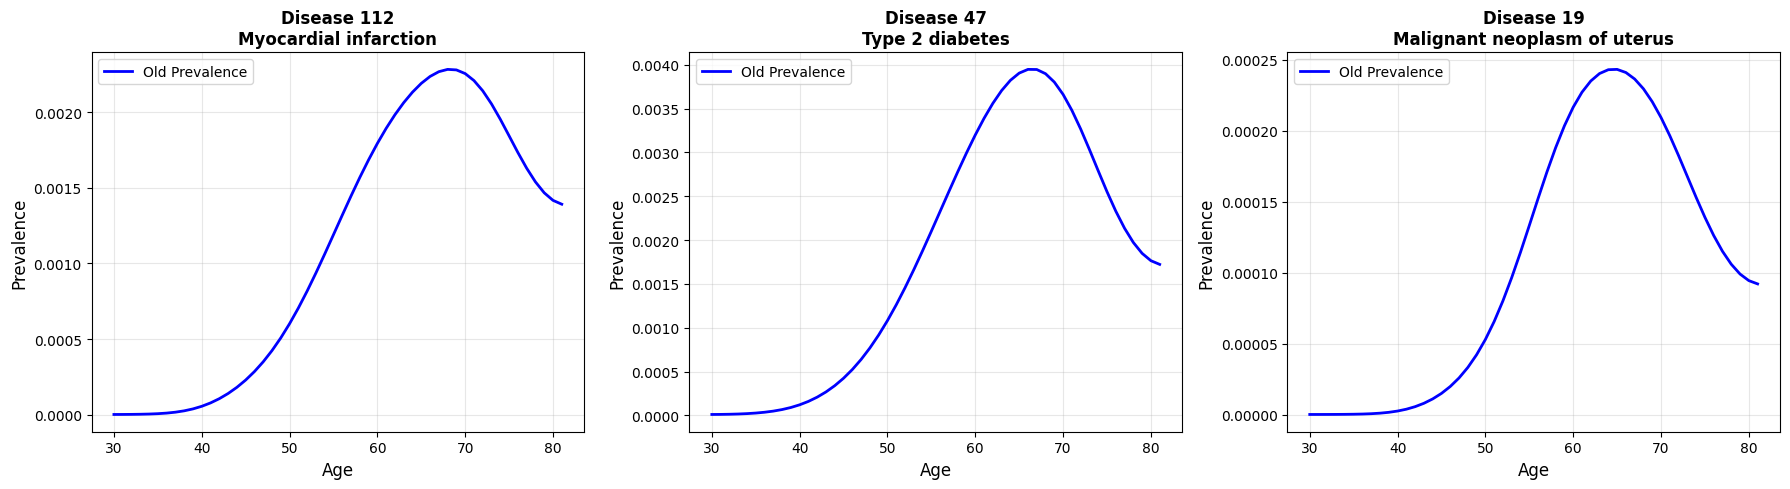


Old prevalence shape: (348, 52)
Sample diseases: [112, 47, 19]
  Disease 112: Myocardial infarction
  Disease 47: Type 2 diabetes
  Disease 19: Malignant neoplasm of uterus


In [42]:
# Compute new prevalence with at-risk filtering using corrected E
print("="*80)
print("COMPUTING NEW PREVALENCE WITH AT-RISK FILTERING")
print("="*80)

def compute_smoothed_prevalence_at_risk(Y, E_corrected, enrollment_ages, window_size=5, smooth_on_logit=True):
    """
    Compute smoothed prevalence with proper at-risk filtering.
    
    Parameters:
    -----------
    Y : torch.Tensor (N × D × T)
    E_corrected : torch.Tensor (N × D) - corrected event/censor times
    enrollment_ages : np.ndarray (N,) - enrollment ages for each person
    window_size : int - Gaussian smoothing window size
    smooth_on_logit : bool - Smooth on logit scale
    """
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(E_corrected):
        E_corrected = E_corrected.numpy()
    
    N, D, T = Y.shape
    prevalence_t = np.zeros((D, T))
    
    # Convert timepoints to ages (assuming timepoint 0 = age 30)
    timepoint_ages = np.arange(T) + 30
    
    print(f"Computing prevalence for {D} diseases, {T} timepoints...")
    
    # Convert E_corrected to numpy if needed
    if torch.is_tensor(E_corrected):
        E_corrected_np = E_corrected.numpy()
    else:
        E_corrected_np = E_corrected
    
    for d in range(D):
        if d % 50 == 0:
            print(f"  Processing disease {d}/{D}...")
        
        for t in range(T):
            age_t = timepoint_ages[t]
            
            # Only include people who:
            # 1. Were enrolled BEFORE age_t (so they've been observed at that age)
            #    OR enrolled at age_t but have minimum follow-up
            # 2. Were still at risk at timepoint t (not censored/event before t)
            # 
            # Use < instead of <= to exclude people enrolled at exactly that age
            # (they haven't had time to develop incident disease yet)
            #enroll_mask = (enrollment_ages < age_t)  # Enrolled BEFORE age_t
            #e_mask = (E_corrected_np[:, d] >= t)  # Still at risk at timepoint t
            at_risk_mask = (E_corrected_np[:, d] >= t) 
            
            # Alternative: Include people enrolled at exactly age_t only if they have minimum follow-up
            # For now, let's try excluding them entirely to see if that fixes the U-shape
            
            if at_risk_mask.sum() > 0:
                if torch.is_tensor(Y):
                    prevalence_t[d, t] = Y[at_risk_mask, d, t].numpy().mean()
                else:
                    prevalence_t[d, t] = Y[at_risk_mask, d, t].mean()
            else:
                prevalence_t[d, t] = np.nan
        
        # Smooth as before
        if smooth_on_logit:
            epsilon = 1e-8
            # Handle NaN values
            valid_mask = ~np.isnan(prevalence_t[d, :])
            if valid_mask.sum() > 0:
                logit_prev = np.full(T, np.nan)
                logit_prev[valid_mask] = np.log(
                    (prevalence_t[d, valid_mask] + epsilon) / 
                    (1 - prevalence_t[d, valid_mask] + epsilon)
                )
                # Smooth only valid values
                smoothed_logit = gaussian_filter1d(
                    np.nan_to_num(logit_prev, nan=0), 
                    sigma=window_size
                )
                # Restore NaN where original was NaN
                smoothed_logit[~valid_mask] = np.nan
                prevalence_t[d, :] = 1 / (1 + np.exp(-smoothed_logit))
        else:
            prevalence_t[d, :] = gaussian_filter1d(
                np.nan_to_num(prevalence_t[d, :], nan=0), 
                sigma=window_size
            )
    
    return prevalence_t

# Load enrollment ages from censor_df
censor_df = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/censor_info.csv')
enrollment_ages = censor_df['age'].values  # Should match Y/E order

# Compute new prevalence
print("\nComputing new prevalence with at-risk filtering...")
new_prevalence_t = compute_smoothed_prevalence_at_risk(
    Y=Y, 
    E_corrected=E_corrected, 
    enrollment_ages=enrollment_ages,
    window_size=5,
    smooth_on_logit=True
)

print(f"\nNew prevalence shape: {new_prevalence_t.shape}")
print("Done!")


COMPUTING NEW PREVALENCE WITH AT-RISK FILTERING

Computing new prevalence with at-risk filtering...
Computing prevalence for 348 diseases, 52 timepoints...
  Processing disease 0/348...
  Processing disease 50/348...
  Processing disease 100/348...
  Processing disease 150/348...
  Processing disease 200/348...
  Processing disease 250/348...
  Processing disease 300/348...

New prevalence shape: (348, 52)
Done!


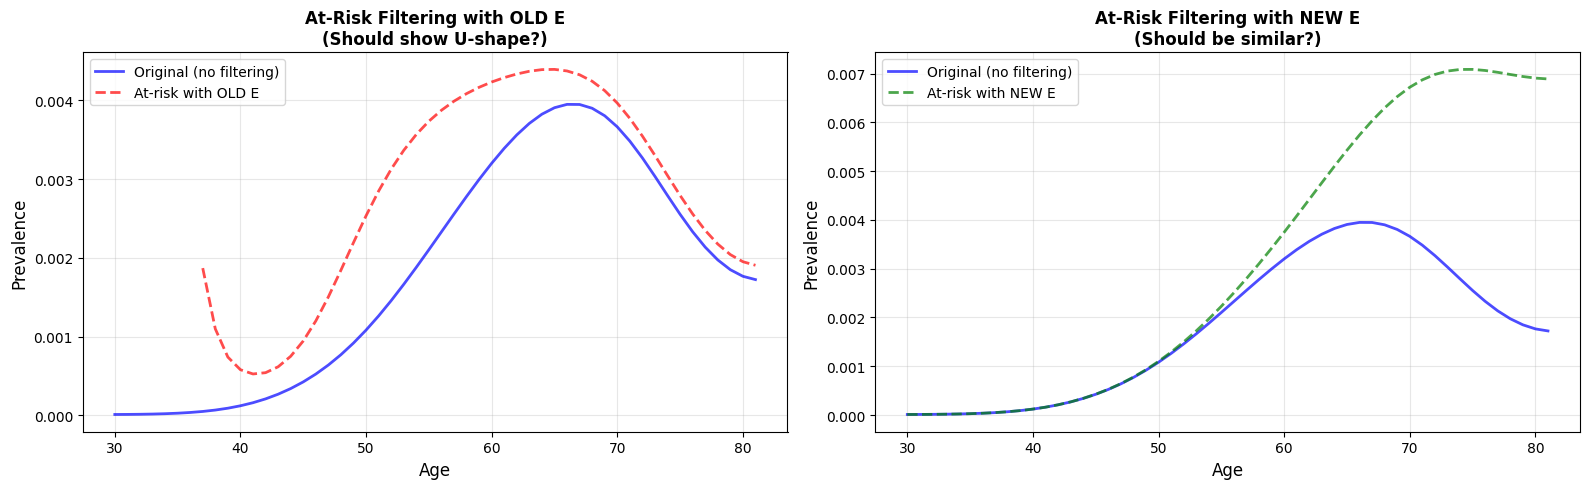


CONCLUSION:
If BOTH show U-shape, the problem is with the at-risk filtering logic,
not with the E correction. The filtering logic needs to be fixed.


In [46]:

# Left: Old E
# Compare for disease 112
d_idx = 47
ages = np.arange(30, 30 + T)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(ages, oldp[d_idx, :], 'b-', linewidth=2, label='Original (no filtering)', alpha=0.7)
axes[0].plot(ages, test_prev_old_E[d_idx, :], 'r--', linewidth=2, label='At-risk with OLD E', alpha=0.7)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Prevalence', fontsize=12)
axes[0].set_title('At-Risk Filtering with OLD E\n(Should show U-shape?)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: New E
axes[1].plot(ages, oldp[d_idx, :], 'b-', linewidth=2, label='Original (no filtering)', alpha=0.7)
axes[1].plot(ages, new_prevalence_t[d_idx, :], 'g--', linewidth=2, label='At-risk with NEW E', alpha=0.7)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Prevalence', fontsize=12)
axes[1].set_title('At-Risk Filtering with NEW E\n(Should be similar?)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("If BOTH show U-shape, the problem is with the at-risk filtering logic,")
print("not with the E correction. The filtering logic needs to be fixed.")


In [24]:
# This is the same as max_censor in the UKB code
import pandas as pd
# For AOU:

import rpy2.robjects as robjects

import rpy2.robjects as robjects
import numpy as np
import os as os
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()
aou_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/aou_sub.csv')
aou_max_followup = aou_df.groupby('eid')['age_diag'].max().reset_index()
aou_max_followup.columns = ['eid', 'max_censor']
aou_max_followup['age'] = aou_max_followup['max_censor']  # Enrollment age if you have it, or use max_censor

# Save as censor_info for AOU
aou_max_followup.to_csv('/Users/sarahurbut/aladynoulli2/aou_censor_info.csv', index=False)


censor_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/aou_censor_info.csv')
T = 52
E=np.array(robjects.r['readRDS']('/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p//aou_fromdl/E_binary.rds'))
# Convert to PyTorch tensors

E= torch.FloatTensor(E)


# Convert to timepoints
max_timepoints = torch.tensor(
    (censor_df['max_censor'].values - 30).clip(0, T-1).astype(int)
)

# Only update censored cases (where E == T-1)
censored_mask = (E == T - 1)  # Shape: (N, D)

# For each patient, cap censored diseases to their max_timepoint
# Expand max_timepoints to match E shape
max_timepoints_expanded = max_timepoints.unsqueeze(1).expand_as(E)

# Update only censored positions
E_corrected = torch.where(
    censored_mask,
    torch.minimum(E, max_timepoints_expanded),
    E  # Keep event times as-is
)

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files

Y=np.array(robjects.r['readRDS']('/Users/sarahurbut/Library/CloudStorage/DB_backup/aou_fromdl/Y_binary.rds'))

print("\nComputing new prevalence with at-risk filtering...")
new_prevalence_t = compute_smoothed_prevalence_at_risk(
    Y=Y, 
    E_corrected=E_corrected, 
    enrollment_ages=enrollment_ages,
    window_size=5,
    smooth_on_logit=True
)

print(f"\nNew prevalence shape: {new_prevalence_t.shape}")
print("Done!")


NameError: name 'numpy2ri' is not defined

In [48]:
# Save corrected prevalence
print("="*80)
print("SAVING CORRECTED PREVALENCE")
print("="*80)

# Save as numpy array
save_path_npy = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.npy'
np.save(save_path_npy, new_prevalence_t)
print(f"Saved prevalence (numpy): {save_path_npy}")
print(f"  Shape: {new_prevalence_t.shape}")
print(f"  Dtype: {new_prevalence_t.dtype}")

# Also save as torch tensor for consistency with other data
save_path_pt = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.pt'
torch.save(torch.tensor(new_prevalence_t, dtype=torch.float32), save_path_pt)
print(f"\nSaved prevalence (torch): {save_path_pt}")

# Compute and save logit version (for model initialization)
epsilon = 1e-8
logit_prev_t_corrected = np.log(
    (new_prevalence_t + epsilon) / (1 - new_prevalence_t + epsilon)
)
save_path_logit = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/logit_prev_t_corrected.npy'
np.save(save_path_logit, logit_prev_t_corrected)
print(f"\nSaved logit prevalence (numpy): {save_path_logit}")
print(f"  Shape: {logit_prev_t_corrected.shape}")

save_path_logit_pt = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/logit_prev_t_corrected.pt'
torch.save(torch.tensor(logit_prev_t_corrected, dtype=torch.float32), save_path_logit_pt)
print(f"Saved logit prevalence (torch): {save_path_logit_pt}")

print("\n" + "="*80)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*80)
print("\nFiles saved:")
print(f"  1. {save_path_npy}")
print(f"  2. {save_path_pt}")
print(f"  3. {save_path_logit}")
print(f"  4. {save_path_logit_pt}")
print("\nThese can now be used for model refitting!")

SAVING CORRECTED PREVALENCE
Saved prevalence (numpy): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.npy
  Shape: (348, 52)
  Dtype: float64

Saved prevalence (torch): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.pt

Saved logit prevalence (numpy): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/logit_prev_t_corrected.npy
  Shape: (348, 52)
Saved logit prevalence (torch): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/logit_prev_t_corrected.pt

ALL FILES SAVED SUCCESSFULLY

Files saved:
  1. /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.npy
  2. /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.pt
  3. /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/logit_prev_t_corrected.npy
  4. /Users/sarahurbut/Library/CloudStorage

In [69]:
%run /Users/sarahurbut/aladynoulli2/test_vectorized_equivalence.py

TESTING EQUIVALENCE: Loop vs Vectorized GP Prior Loss

1. Initializing models...

Cluster Sizes:
Cluster 0: 7 diseases
Cluster 1: 8 diseases
Cluster 2: 5 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 7
Base value (first 5): tensor([-8.6434, -1.8497, -1.8254, -1.6180, -7.0606])
Base value centered (first 5): tensor([-2.7855,  4.0083,  4.0325,  4.2399, -1.2027])
Base value centered mean: 3.33786012163273e-08
Gamma init for k=0 (first 5): tensor([-0.0428,  0.2674,  0.3948, -0.0455,  0.1096])

Calculating gamma for k=1:
Number of diseases in cluster: 8
Base value (first 5): tensor([ -9.4587,  -3.2780, -10.9109,  -6.1486,  -4.8991])
Base value centered (first 5): tensor([-3.6500,  2.5307, -5.1022, -0.3399,  0.9096])
Base value centered mean: -4.1961669694501325e-07
Gamma init for k=1 (first 5): tensor([ 0.1281, -0.7156, -0.0966, -0.2780,  0.0819])

Calculating gamma for k=2:
Number of diseases in cluster: 5
Base value (first 5): tensor([-1.7107, -1.7651, -8.7360, -6.41

In [7]:
import torch

old_ckpt = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt', map_location='cpu', weights_only=False)
new_ckpt = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W0.0001_batch_0_10000.pt', map_location='cpu', weights_only=False)

# Compare phi
diff = torch.abs(old['model_state_dict']['lambda_'] - new['model_state_dict']['lambda_'])
print(f"Max lambda difference: {diff.max().item():.6e}")
print(f"Mean lambda difference: {diff.mean().item():.6e}")


Max lambda difference: 7.126526e-01
Mean lambda difference: 5.287133e-05


In [8]:

# Check if pi is saved directly
if 'pi' in old_ckpt and 'pi' in new_ckpt:
    print("\nPi found directly in checkpoints!")
    old_pi = old_ckpt['pi'].cpu() if isinstance(old_ckpt['pi'], torch.Tensor) else torch.tensor(old_ckpt['pi'])
    new_pi = new_ckpt['pi'].cpu() if isinstance(new_ckpt['pi'], torch.Tensor) else torch.tensor(new_ckpt['pi'])
else:
    print("\nComputing pi from saved parameters...")
    
    # Get parameters
    old_state = old_ckpt.get('model_state_dict', old_ckpt)
    new_state = new_ckpt.get('model_state_dict', new_ckpt)
    
    # Extract phi, lambda, kappa
    old_phi = old_state['phi'].cpu() if 'phi' in old_state else old_ckpt['phi'].cpu()
    new_phi = new_state['phi'].cpu() if 'phi' in new_state else new_ckpt['phi'].cpu()
    
    old_lambda = old_state['lambda_'].cpu() if 'lambda_' in old_state else None
    new_lambda = new_state['lambda_'].cpu() if 'lambda_' in new_state else None
    
    old_kappa = old_state.get('kappa', torch.tensor([1.0])).cpu() if 'kappa' in old_state else torch.tensor([1.0])
    new_kappa = new_state.get('kappa', torch.tensor([1.0])).cpu() if 'kappa' in new_state else torch.tensor([1.0])
    
    # Compute pi = sigmoid(softmax(lambda) @ sigmoid(phi)) * kappa
    # pi = einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
    # where theta = softmax(lambda) and phi_prob = sigmoid(phi)
    
    if old_lambda is not None and new_lambda is not None:
        # Compute theta
        old_theta = torch.softmax(old_lambda, dim=1)  # [N, K, T]
        new_theta = torch.softmax(new_lambda, dim=1)
        
        # Compute phi_prob
        old_phi_prob = torch.sigmoid(old_phi)  # [K, D, T]
        new_phi_prob = torch.sigmoid(new_phi)
        
        # Compute pi
        old_pi = torch.einsum('nkt,kdt->ndt', old_theta, old_phi_prob) * old_kappa
        new_pi = torch.einsum('nkt,kdt->ndt', new_theta, new_phi_prob) * new_kappa
        
        # Clamp to avoid numerical issues
        epsilon = 1e-8
        old_pi = torch.clamp(old_pi, epsilon, 1 - epsilon)
        new_pi = torch.clamp(new_pi, epsilon, 1 - epsilon)
    else:
        print("  ✗ Cannot compute pi - lambda not found in checkpoints")
        print("  Available keys in old_ckpt:", list(old_ckpt.keys()))
        print("  Available keys in new_ckpt:", list(new_ckpt.keys()))
        exit(1)

# Compare pi values
print(f"\nPi shape: {old_pi.shape}")
print(f"Expected: [N, D, T] = [patients, diseases, timepoints]")

diff = torch.abs(old_pi - new_pi)
max_diff = diff.max().item()
mean_diff = diff.mean().item()
std_diff = diff.std().item()

print(f"\nPi comparison:")
print(f"  Max difference: {max_diff:.6e}")
print(f"  Mean difference: {mean_diff:.6e}")
print(f"  Std difference: {std_diff:.6e}")

# Find where max difference occurs
max_idx = torch.unravel_index(torch.argmax(diff), diff.shape)
print(f"\nMax difference location: patient={max_idx[0]}, disease={max_idx[1]}, time={max_idx[2]}")
print(f"  Old pi value: {old_pi[max_idx].item():.6f}")
print(f"  New pi value: {new_pi[max_idx].item():.6f}")
print(f"  Difference: {diff[max_idx].item():.6e}")
print(f"  Relative difference: {(diff[max_idx] / (old_pi[max_idx] + 1e-8)).item() * 100:.4f}%")

# Compare by disease (average across patients and time)
print(f"\nMean pi difference by disease (top 10):")
disease_diffs = diff.mean(dim=(0, 2))  # Average over patients and time
top_diseases = torch.topk(disease_diffs, k=min(10, disease_diffs.shape[0]))
for i, (d_idx, diff_val) in enumerate(zip(top_diseases.indices, top_diseases.values)):
    print(f"  Disease {d_idx.item()}: mean diff = {diff_val.item():.6e}")

# Compare by timepoint (average across patients and diseases)
print(f"\nMean pi difference by timepoint:")
time_diffs = diff.mean(dim=(0, 1))  # Average over patients and diseases
for t in range(min(10, time_diffs.shape[0])):
    print(f"  Time {t}: mean diff = {time_diffs[t].item():.6e}")

# Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if max_diff < 1e-4:
    print("✓ PI VALUES MATCH CLOSELY (max diff < 1e-4)")
elif max_diff < 1e-2:
    print("⚠ PI VALUES ARE SIMILAR (max diff < 1e-2)")
    print("  Small differences expected due to phi/lambda differences")
else:
    print("✗ PI VALUES DIFFER SIGNIFICANTLY (max diff >= 1e-2)")

print(f"\nMean difference: {mean_diff:.6e} (very small = good)")
print(f"Max difference: {max_diff:.6e}")



Computing pi from saved parameters...

Pi shape: torch.Size([10000, 348, 52])
Expected: [N, D, T] = [patients, diseases, timepoints]

Pi comparison:
  Max difference: 1.732152e-03
  Mean difference: 4.366704e-08
  Std difference: 8.088113e-07

Max difference location: patient=1535, disease=52, time=23
  Old pi value: 0.018554
  New pi value: 0.016822
  Difference: 1.732152e-03
  Relative difference: 9.3358%

Mean pi difference by disease (top 10):
  Disease 301: mean diff = 9.950813e-07
  Disease 109: mean diff = 7.392598e-07
  Disease 299: mean diff = 4.439434e-07
  Disease 52: mean diff = 3.855184e-07
  Disease 194: mean diff = 3.466209e-07
  Disease 203: mean diff = 3.374299e-07
  Disease 112: mean diff = 2.892235e-07
  Disease 195: mean diff = 2.694932e-07
  Disease 145: mean diff = 2.593312e-07
  Disease 33: mean diff = 2.318327e-07

Mean pi difference by timepoint:
  Time 0: mean diff = 1.544803e-09
  Time 1: mean diff = 9.825170e-10
  Time 2: mean diff = 9.699588e-10
  Time 3: 

In [10]:
#!/usr/bin/env python
"""
Compare correlations between old and new pi values
This checks if the patterns/relationships are preserved
"""

import torch
import numpy as np
from scipy.stats import pearsonr

print("="*80)
print("COMPARING PI CORRELATIONS")
print("="*80)

# Get parameters and compute pi
old_state = old_ckpt.get('model_state_dict', old_ckpt)
new_state = new_ckpt.get('model_state_dict', new_ckpt)

old_phi = old_state['phi'].cpu() if 'phi' in old_state else old_ckpt['phi'].cpu()
new_phi = new_state['phi'].cpu() if 'phi' in new_state else new_ckpt['phi'].cpu()

old_lambda = old_state['lambda_'].cpu() if 'lambda_' in old_state else None
new_lambda = new_state['lambda_'].cpu() if 'lambda_' in new_state else None

old_kappa = old_state.get('kappa', torch.tensor([1.0])).cpu() if 'kappa' in old_state else torch.tensor([1.0])
new_kappa = new_state.get('kappa', torch.tensor([1.0])).cpu() if 'kappa' in new_state else torch.tensor([1.0])

# Compute pi
old_theta = torch.softmax(old_lambda, dim=1)  # [N, K, T]
new_theta = torch.softmax(new_lambda, dim=1)

old_phi_prob = torch.sigmoid(old_phi)  # [K, D, T]
new_phi_prob = torch.sigmoid(new_phi)

old_pi = torch.einsum('nkt,kdt->ndt', old_theta, old_phi_prob) * old_kappa
new_pi = torch.einsum('nkt,kdt->ndt', new_theta, new_phi_prob) * new_kappa

epsilon = 1e-8
old_pi = torch.clamp(old_pi, epsilon, 1 - epsilon)
new_pi = torch.clamp(new_pi, epsilon, 1 - epsilon)

print(f"\nPi shape: {old_pi.shape}")

# Flatten for overall correlation
old_flat = old_pi.flatten().numpy()
new_flat = new_pi.flatten().numpy()

corr_overall, p_val_overall = pearsonr(old_flat, new_flat)
print(f"\n1. OVERALL CORRELATION (all pi values flattened):")
print(f"   Correlation: {corr_overall:.8f}")
print(f"   P-value: {p_val_overall:.2e}")
print(f"   R²: {corr_overall**2:.8f}")

# Correlation by disease (across all patients and timepoints)
print(f"\n2. CORRELATION BY DISEASE (top 10 best, bottom 10 worst):")
disease_corrs = []
for d in range(old_pi.shape[1]):
    old_d = old_pi[:, d, :].flatten().numpy()
    new_d = new_pi[:, d, :].flatten().numpy()
    corr, _ = pearsonr(old_d, new_d)
    disease_corrs.append((d, corr))

disease_corrs_sorted = sorted(disease_corrs, key=lambda x: x[1])
print(f"\n   Top 10 best correlations:")
for d, corr in disease_corrs_sorted[-10:]:
    print(f"     Disease {d}: r = {corr:.8f}")

print(f"\n   Bottom 10 worst correlations:")
for d, corr in disease_corrs_sorted[:10]:
    print(f"     Disease {d}: r = {corr:.8f}")

# Correlation by timepoint (across all patients and diseases)
print(f"\n3. CORRELATION BY TIMEPOINT:")
time_corrs = []
for t in range(old_pi.shape[2]):
    old_t = old_pi[:, :, t].flatten().numpy()
    new_t = new_pi[:, :, t].flatten().numpy()
    corr, _ = pearsonr(old_t, new_t)
    time_corrs.append((t, corr))

for t, corr in time_corrs[:10]:  # Show first 10
    print(f"   Time {t}: r = {corr:.8f}")

print(f"\n   Min correlation: {min(time_corrs, key=lambda x: x[1])[1]:.8f} at time {min(time_corrs, key=lambda x: x[1])[0]}")
print(f"   Max correlation: {max(time_corrs, key=lambda x: x[1])[1]:.8f} at time {max(time_corrs, key=lambda x: x[1])[0]}")

# Correlation by patient (across all diseases and timepoints)
print(f"\n4. CORRELATION BY PATIENT (sample of 10):")
patient_corrs = []
for n in range(min(100, old_pi.shape[0])):  # Sample first 100 patients
    old_n = old_pi[n, :, :].flatten().numpy()
    new_n = new_pi[n, :, :].flatten().numpy()
    corr, _ = pearsonr(old_n, new_n)
    patient_corrs.append((n, corr))

patient_corrs_sorted = sorted(patient_corrs, key=lambda x: x[1])
print(f"\n   Sample correlations (showing range):")
for n, corr in patient_corrs_sorted[:5]:  # Worst 5
    print(f"     Patient {n}: r = {corr:.8f}")
print(f"     ...")
for n, corr in patient_corrs_sorted[-5:]:  # Best 5
    print(f"     Patient {n}: r = {corr:.8f}")

# Summary statistics
all_disease_corrs = [c for _, c in disease_corrs]
all_time_corrs = [c for _, c in time_corrs]
all_patient_corrs = [c for _, c in patient_corrs]

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Overall correlation: {corr_overall:.8f}")
print(f"\nBy disease:")
print(f"  Mean correlation: {np.mean(all_disease_corrs):.8f}")
print(f"  Min correlation: {np.min(all_disease_corrs):.8f}")
print(f"  Max correlation: {np.max(all_disease_corrs):.8f}")
print(f"  Std correlation: {np.std(all_disease_corrs):.8f}")

print(f"\nBy timepoint:")
print(f"  Mean correlation: {np.mean(all_time_corrs):.8f}")
print(f"  Min correlation: {np.min(all_time_corrs):.8f}")
print(f"  Max correlation: {np.max(all_time_corrs):.8f}")

print(f"\nBy patient (sample of {len(all_patient_corrs)}):")
print(f"  Mean correlation: {np.mean(all_patient_corrs):.8f}")
print(f"  Min correlation: {np.min(all_patient_corrs):.8f}")
print(f"  Max correlation: {np.max(all_patient_corrs):.8f}")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
if corr_overall > 0.99:
    print("✓ EXCELLENT: Correlations > 0.99 indicate the patterns are nearly identical")
elif corr_overall > 0.95:
    print("✓ VERY GOOD: Correlations > 0.95 indicate strong agreement in patterns")
elif corr_overall > 0.90:
    print("⚠ GOOD: Correlations > 0.90 indicate good agreement, but some differences exist")
else:
    print("✗ WARNING: Correlations < 0.90 suggest significant pattern differences")

print(f"\nHigh correlations mean the relative patterns/relationships are preserved,")
print(f"even if absolute values differ slightly (which is expected given phi/lambda differences).")


COMPARING PI CORRELATIONS

Pi shape: torch.Size([10000, 348, 52])

1. OVERALL CORRELATION (all pi values flattened):
   Correlation: 0.99999976
   P-value: 0.00e+00
   R²: 0.99999952

2. CORRELATION BY DISEASE (top 10 best, bottom 10 worst):

   Top 10 best correlations:
     Disease 241: r = 0.99999998
     Disease 152: r = 0.99999998
     Disease 155: r = 0.99999999
     Disease 239: r = 0.99999999
     Disease 235: r = 0.99999999
     Disease 242: r = 0.99999999
     Disease 234: r = 0.99999999
     Disease 151: r = 0.99999999
     Disease 240: r = 0.99999999
     Disease 232: r = 0.99999999

   Bottom 10 worst correlations:
     Disease 301: r = 0.99998718
     Disease 127: r = 0.99999463
     Disease 125: r = 0.99999761
     Disease 131: r = 0.99999772
     Disease 119: r = 0.99999786
     Disease 126: r = 0.99999790
     Disease 106: r = 0.99999798
     Disease 168: r = 0.99999804
     Disease 111: r = 0.99999833
     Disease 113: r = 0.99999844

3. CORRELATION BY TIMEPOINT:
   T

In [ ]:

model = AladynSurvivalFixedKernelsAvgLoss_clust(
N=Y.shape[0],
D=Y.shape[1],
T=Y.shape[2],
K=essentials['K'],
P=essentials['P'],
G=G,
Y=Y,
prevalence_t=essentials['prevalence_t']
)
# Visualize the clusters
disease_names_list=essentials['disease_names']
model.visualize_clusters(disease_names_list)
model.visualize_initialization()

In [6]:
import scipy.sparse as sp
import rpy2.robjects as robjects
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def load_sparse_and_convert(path):
    """
    Load sparse RDS and convert to dense tensor for training
    Y shape: (n_patients, n_diseases, n_timepoints)
    """
    # Load R object
    r_sparse = robjects.r.readRDS(path)
    n_timepoints = len(r_sparse)
    
    # Get dimensions from first matrix
    matrix = r_sparse[0]
    n_patients = matrix.slots['Dim'][0]
    n_diseases = matrix.slots['Dim'][1]
    print(f"Dimensions: {n_patients} patients, {n_diseases} diseases, {n_timepoints} timepoints")
    
    # Initialize with correct shape (N, D, T)
    full_data = np.zeros((n_patients, n_diseases, n_timepoints))
    
    # Convert each sparse matrix
    for t in range(n_timepoints):
        if t % 10 == 0:
            print(f"Converting matrix {t}...")
            
        matrix = r_sparse[t]
        data = np.array(matrix.slots['x'])
        rows = np.array(matrix.slots['i'])
        ptr = np.array(matrix.slots['p'])
        
        sparse_mat = sp.csc_matrix((data, rows, ptr), 
                                 shape=(n_patients, n_diseases))
        
        # Store in the correct dimension
        full_data[:, :, t] = sparse_mat.toarray()
    
    print("Conversion complete!")
    return torch.FloatTensor(full_data)

# Try loading with progress updates
try:
    Y_tensor = load_sparse_and_convert('/Users/sarahurbut/Dropbox (Personal)/sparse_array.rds')
    print("Final tensor shape:", Y_tensor.shape)
    print("Memory usage:", Y_tensor.element_size() * Y_tensor.nelement() / 1e9, "GB")
except Exception as e:
    print("Error occurred:")
    print(e)
    import traceback
    traceback.print_exc()

R[write to console]: Loading required package: Matrix



Dimensions: 407878 patients, 348 diseases, 52 timepoints
Converting matrix 0...
Converting matrix 10...
Converting matrix 20...
Converting matrix 30...
Converting matrix 40...
Converting matrix 50...
Conversion complete!
Final tensor shape: torch.Size([407878, 348, 52])
Memory usage: 29.523841152 GB


In [ ]:
def create_event_matrix(Y_tensor):
    """
    Create event times matrix E from dense tensor Y
    Y_tensor shape: (n_patients, n_diseases, n_timepoints)
    Returns: E matrix where censored cases are marked as T-1 (49)
    """
    n_patients, n_diseases, n_times = Y_tensor.shape
    max_time = n_times - 1  # Should be 52 for your data
    
    # Initialize with censoring time (T-1)
    E = torch.full((n_patients, n_diseases), max_time)
    
    # Find first events
    events = torch.nonzero(Y_tensor == 1)
    
    for patient, disease, time in events:
        if time < E[patient, disease]:
            E[patient, disease] = time
            
    print(f"Found events for {(E != max_time).sum().item()} patient-disease pairs")
    print(f"Censored pairs: {(E == max_time).sum().item()}")
    print(f"Total pairs: {E.shape[0] * E.shape[1]}")
    
    # Validation
    assert torch.all(E <= max_time), "Found event times beyond max time"
    assert torch.all(E >= 0), "Found negative event times"
    
    return E

# Test

E = create_event_matrix(Y_tensor)
print("\nEvent Statistics:")
print(f"Time range: 0 to {Y_tensor.shape[2]-1}")
print(f"Patients with at least one event: {(E != Y_tensor.shape[2]-1).any(dim=1).sum().item()}")
print(f"Average events per patient: {(E != Y_tensor.shape[2]-1).sum().float() / E.shape[0]:.2f}")



Found events for 3255843 patient-disease pairs
Censored pairs: 138685701
Total pairs: 141941544

Event Statistics:
Time range: 0 to 51
Patients with at least one event: 407098
Average events per patient: 7.98


In [ ]:
import pandas as pd
import torch
import numpy as np


FileNotFoundError: [Errno 2] No such file or directory: 'censor_info.csv'

In [8]:
# Specify the path to your data files
import os
import scipy.sparse as sp
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
import numpy as np
import torch
import pandas as pd

# Activate numpy to R interface
numpy2ri.activate()
data_path = "/Users/sarahurbut/Dropbox (Personal)/"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'G_subset_forsparse.rds')))

disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_list_forsparse.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))
disease_names_list = disease_names[0].tolist()
G.shape

(36, 407878)

In [9]:
# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)


G shape after transposition: (407878, 36)


In [10]:
prevalence_t=compute_smoothed_prevalence(Y=Y_tensor,window_size=5)
K=20
T=Y_tensor.shape[2]
N=Y_tensor.shape[0]
D=Y_tensor.shape[1]
print(N)
print(T)
P=G.shape[1]
print(P)

407878
52
36


In [11]:
disease_names=disease_names.T
disease_names

0
0                                  Bacterial enteritis
1                                      Viral Enteritis
2                             Gram negative septicemia
3                              Bacterial infection NOS
4                            Staphylococcus infections
..                                                 ...
343                                     Abdominal pain
344                       Internal derangement of knee
345  Atopic/contact dermatitis due to other or unsp...
346                                             Sepsis
347                                        Other tests

[348 rows x 1 columns]

In [12]:
disease_names_list = disease_names[0].tolist()

In [19]:
notebook_dir = '/Users/sarahurbut/aladynoulli/pyScripts/'
tensor_path = os.path.join(notebook_dir, 'Y_tensor.pt')
torch.save(Y_tensor, tensor_path)

In [13]:
disease_names_list

['Bacterial enteritis',
 'Viral Enteritis',
 'Gram negative septicemia',
 'Bacterial infection NOS',
 'Staphylococcus infections',
 'Streptococcus infection',
 'E. coli',
 'Viral warts & HPV',
 'Viral infection',
 'Candidiasis',
 'Colon cancer',
 'Malignant neoplasm of rectum, rectosigmoid junction, and anus',
 'Neoplasm of unspecified nature of digestive system',
 'Cancer of bronchus; lung',
 'Melanomas of skin',
 'Other non-epithelial cancer of skin',
 'Breast cancer [female]',
 'Malignant neoplasm of female breast',
 'Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]',
 'Malignant neoplasm of uterus',
 'Malignant neoplasm of ovary',
 'Cancer of prostate',
 'Malignant neoplasm of kidney, except pelvis',
 'Malignant neoplasm of bladder',
 'Malignant neoplasm, other',
 'Secondary malignant neoplasm',
 'Secondary malignancy of lymph nodes',
 'Secondary malignancy of respiratory organs',
 'Secondary malignant neoplasm of digestive systems',
 'Secondary malignant neoplasm of l

In [14]:

# Create model
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y_tensor, prevalence_t)




/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 8 diseases
Cluster 2: 31 diseases
Cluster 3: 14 diseases
Cluster 4: 26 diseases
Cluster 5: 29 diseases
Cluster 6: 13 diseases
Cluster 7: 16 diseases
Cluster 8: 87 diseases
Cluster 9: 11 diseases
Cluster 10: 27 diseases
Cluster 11: 8 diseases
Cluster 12: 5 diseases
Cluster 13: 9 diseases
Cluster 14: 10 diseases
Cluster 15: 12 diseases
Cluster 16: 16 diseases
Cluster 17: 14 diseases
Cluster 18: 7 diseases
Initialization complete!



Cluster Assignments:

Cluster 0:
  - Septal Deviations/Turbinate Hypertrophy (prevalence: 0.0003)
  - Nasal polyps (prevalence: 0.0002)
  - Chronic pharyngitis and nasopharyngitis (prevalence: 0.0001)
  - Chronic sinusitis (prevalence: 0.0002)
  - Other upper respiratory disease (prevalence: 0.0003)

Cluster 1:
  - Cancer of bronchus; lung (prevalence: 0.0003)
  - Malignant neoplasm, other (prevalence: 0.0002)
  - Secondary malignant neoplasm (prevalence: 0.0002)
  - Secondary malignancy of lymph nodes (prevalence: 0.0006)
  - Secondary malignancy of respiratory organs (prevalence: 0.0003)
  - Secondary malignant neoplasm of digestive systems (prevalence: 0.0002)
  - Secondary malignant neoplasm of liver (prevalence: 0.0004)
  - Secondary malignancy of bone (prevalence: 0.0003)

Cluster 2:
  - Obesity (prevalence: 0.0018)
  - Major depressive disorder (prevalence: 0.0015)
  - Anxiety disorder (prevalence: 0.0011)
  - Sleep apnea (prevalence: 0.0005)
  - Other peripheral nerve disorder

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:611: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


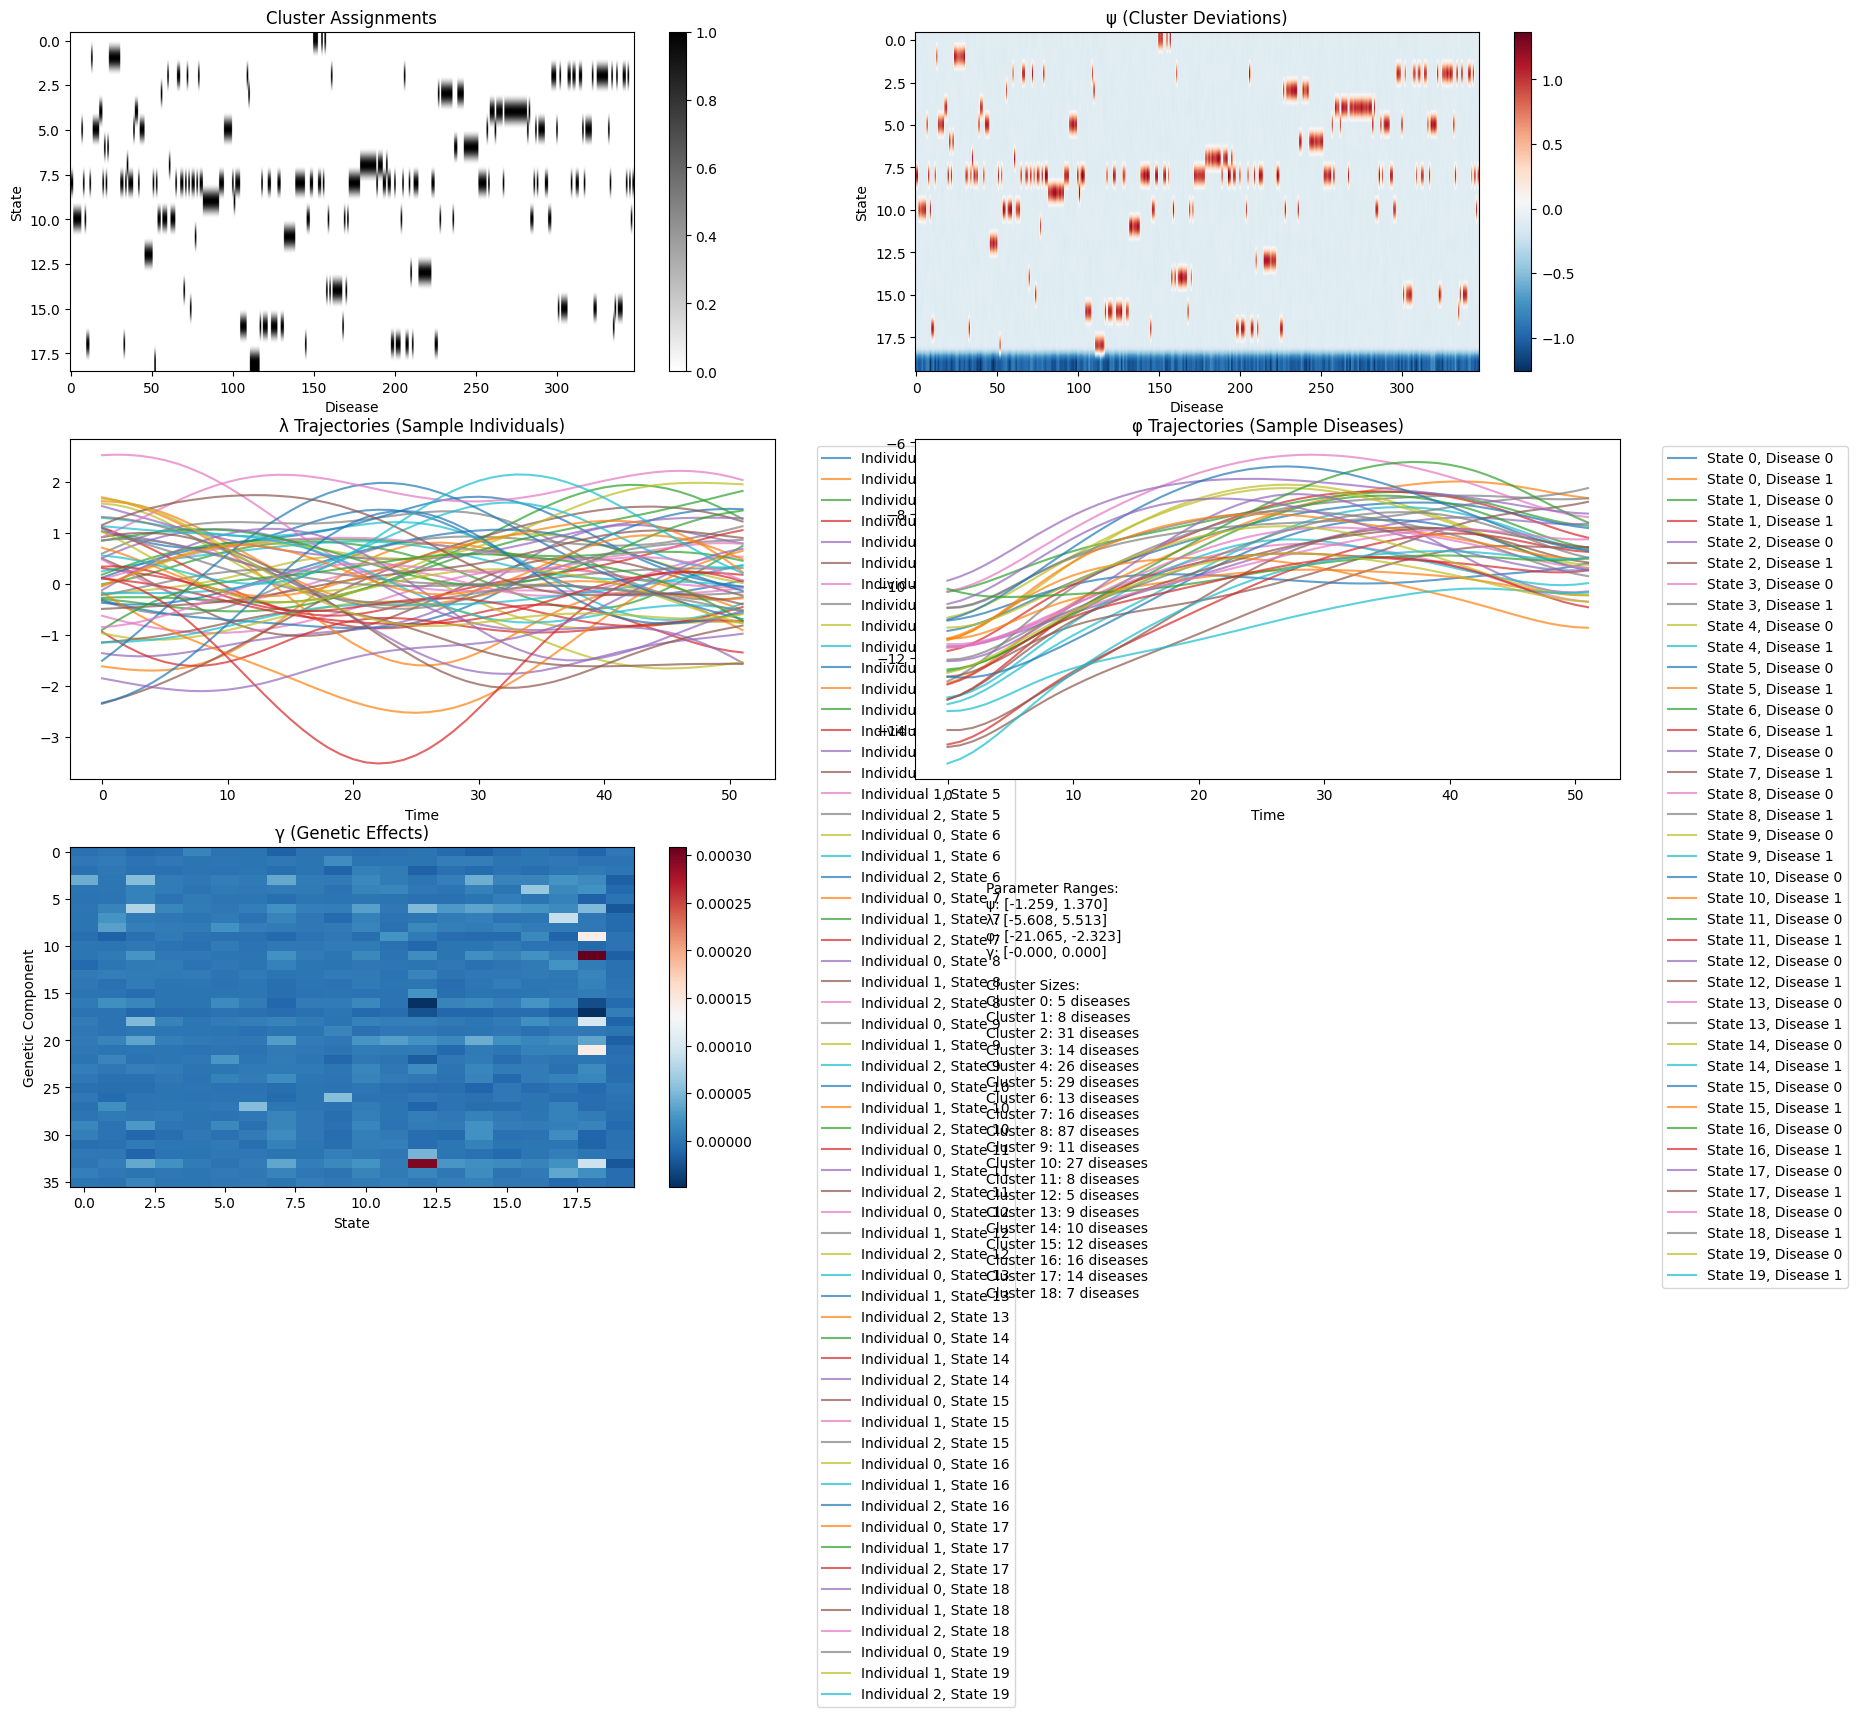

Parameter containing:
tensor([[-0.0944, -0.1117, -0.0958,  ..., -0.1013, -0.0930, -0.0996],
        [-0.1038, -0.1056, -0.0858,  ..., -0.0853, -0.0954, -0.1092],
        [-0.0860, -0.1060, -0.1118,  ..., -0.0870, -0.1022, -0.0784],
        ...,
        [-0.1091, -0.0900, -0.1173,  ..., -0.0879, -0.1174, -0.0842],
        [-0.0836, -0.1057, -0.0920,  ..., -0.1032, -0.0813, -0.1042],
        [-1.0182, -0.9674, -1.0629,  ..., -1.0852, -1.0138, -1.1253]],
       requires_grad=True)

In [15]:

# Visualize the clusters
model.visualize_clusters(disease_names_list)
model.visualize_initialization()
model.psi

In [48]:
G.shape

torch.Size([407878, 36])

In [51]:
def save_model_essentials(Y, E, prevalence_t, G, P, K, disease_names, model, 
                         base_path='/Users/sarahurbut/Dropbox (Personal)/'):
    """
    Save all essential components needed to run the model
    """
    print("Saving essential components...")
    
    # Save large matrices separately
    torch.save(Y, base_path + 'Y_tensor.pt')
    torch.save(E, base_path + 'E_matrix.pt')
    torch.save(G, base_path + 'G_matrix.pt')
    
    # Save other components together
    essentials = {
        'prevalence_t': prevalence_t,
        'P': P,
        'K': K,
        'disease_names': disease_names,
        'clusters': model.clusters,
        'psi': model.psi,
        'model_state': model.state_dict()
    }
    torch.save(essentials, base_path + 'model_essentials.pt')
    
    print("Saved all components:")
    print(f"- Y shape: {Y.shape}")
    print(f"- E shape: {E.shape}")
    print(f"- G shape: {G.shape}")
    print(f"- prevalence_t shape: {prevalence_t.shape}")
    print(f"- P: {P}")
    print(f"- K: {K}")


Saving essential components...
Saved all components:
- Y shape: torch.Size([407878, 348, 52])
- E shape: torch.Size([407878, 348])
- G shape: torch.Size([407878, 36])
- prevalence_t shape: (348, 52)
- P: 36
- K: 20


In [53]:

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Save everything:
save_model_essentials(Y_tensor, E, prevalence_t, G, P, K, disease_names, model)


# Load and initialize model:
Y, E, G, essentials = load_model_essentials()
model = AladynSurvivalFixedKernelsAvgLoss_clust(
N=Y.shape[0],
D=Y.shape[1],
T=Y.shape[2],
K=essentials['K'],
P=essentials['P'],
G=G,
Y=Y,
prevalence_t=essentials['prevalence_t']
)

Saving essential components...
Saved all components:
- Y shape: torch.Size([407878, 348, 52])
- E shape: torch.Size([407878, 348])
- G shape: torch.Size([407878, 36])
- prevalence_t shape: (348, 52)
- P: 36
- K: 20


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:611: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


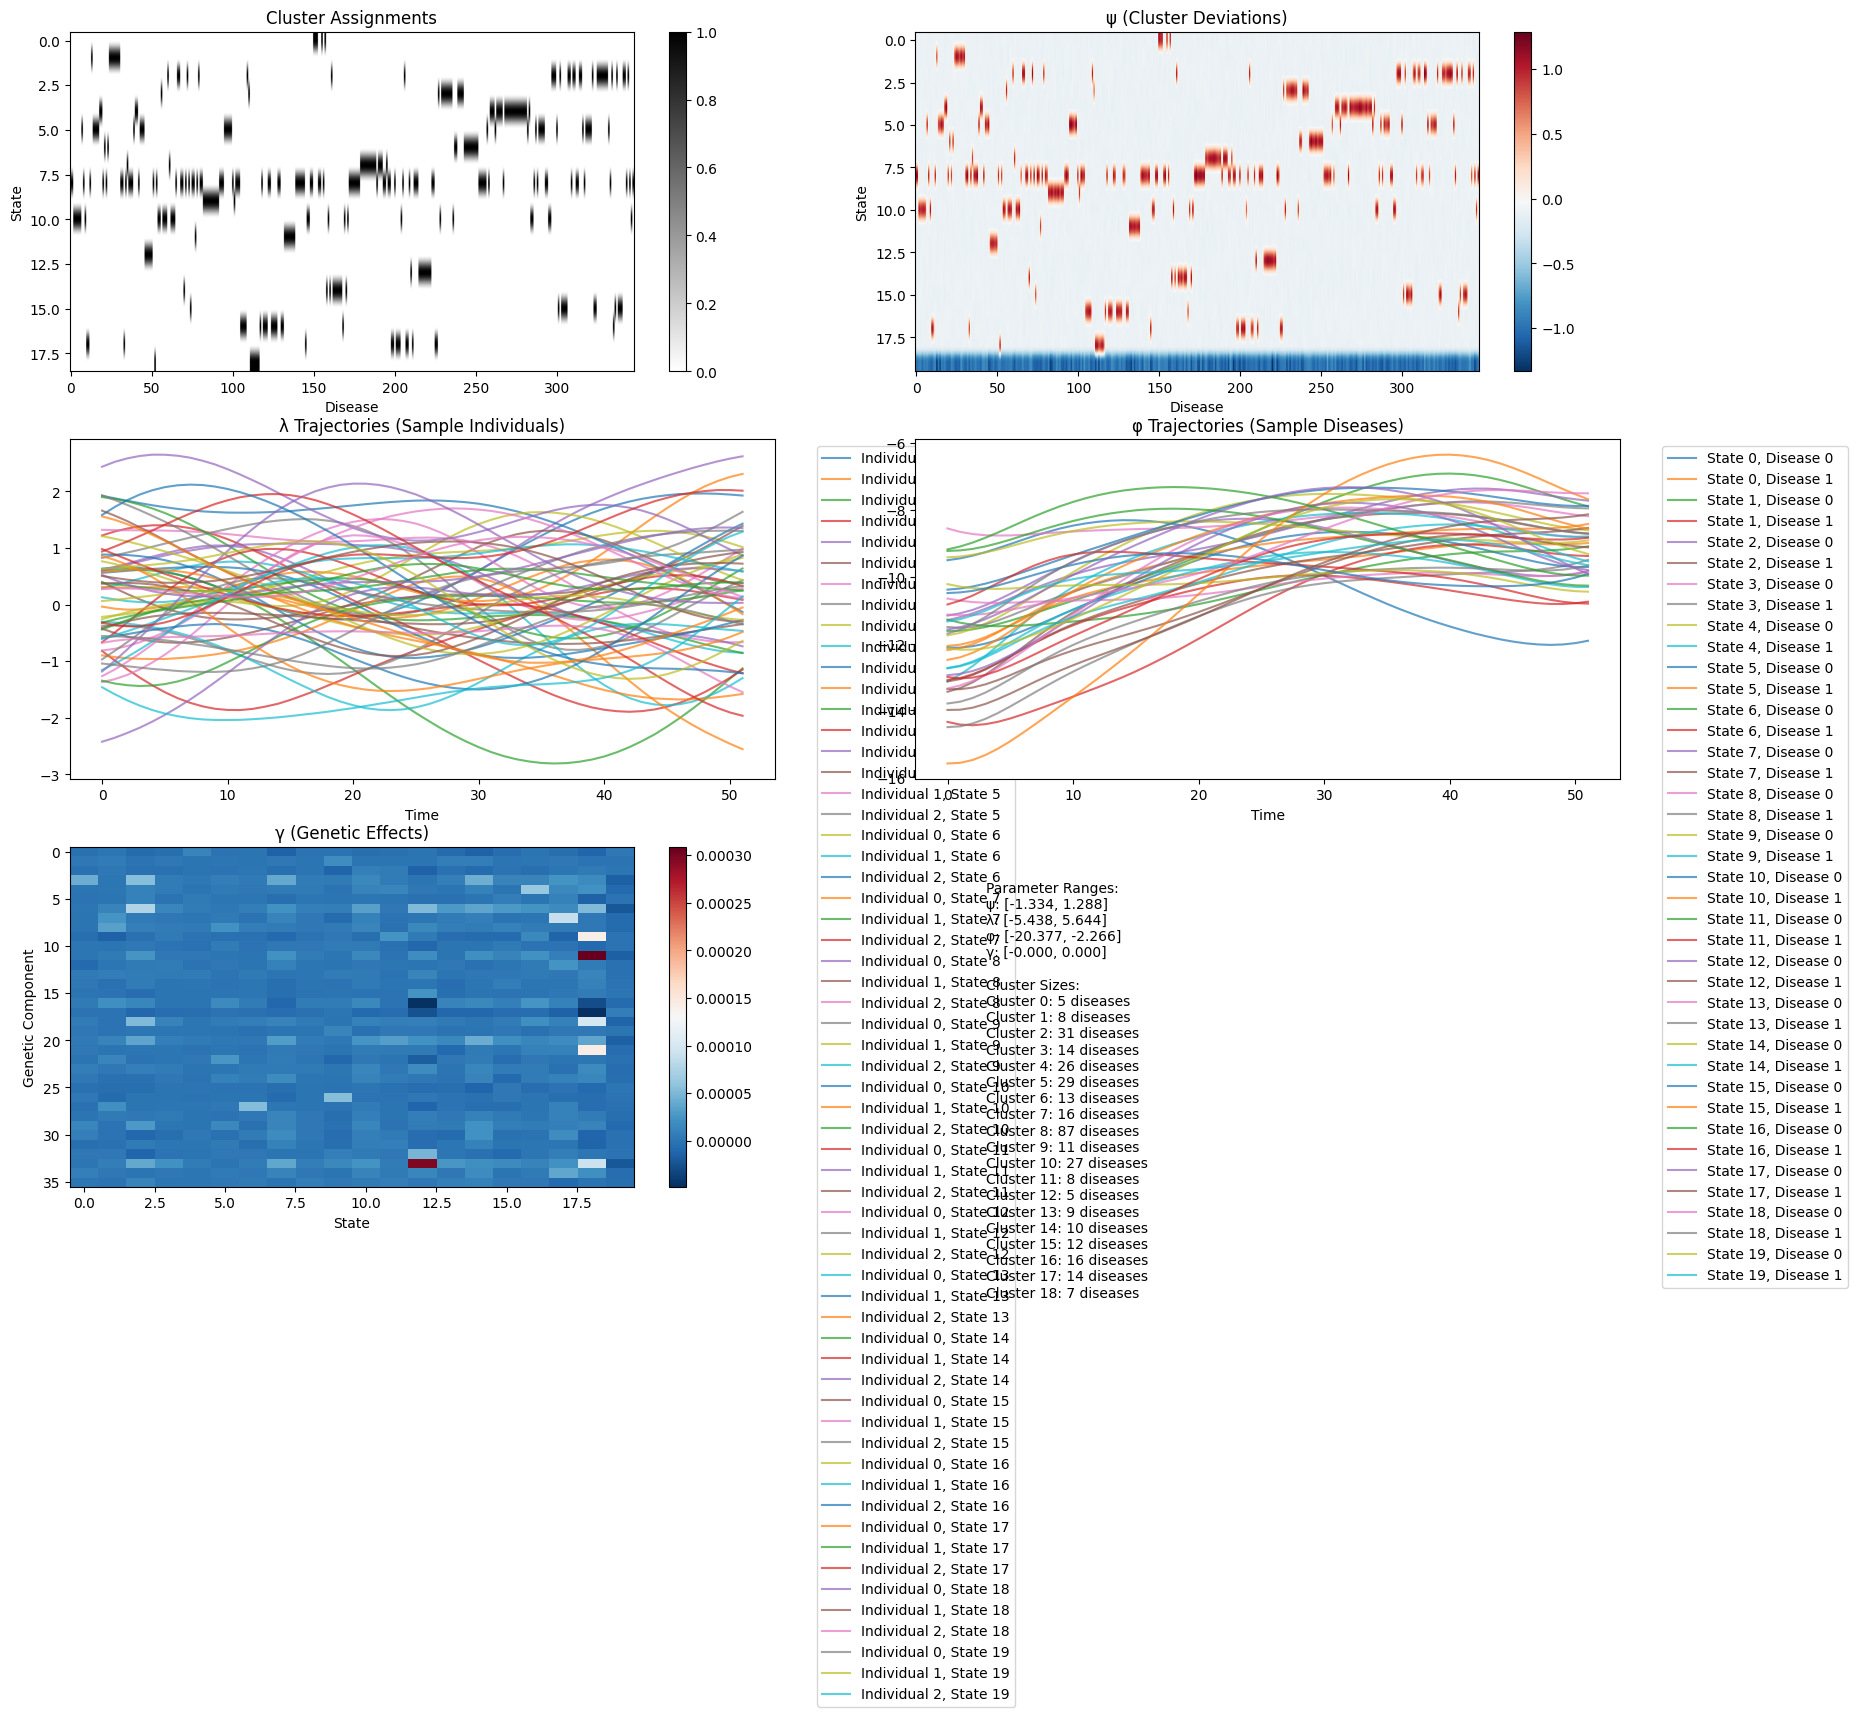

In [55]:
model.visualize_initialization()

In [20]:
model_save_path = '/Users/sarahurbut/aladynoulli/pyScripts/trained_model.pt'

# Save everything
model_state = {
    'model_state': model.state_dict(),
    'Y_tensor': Y_tensor,
    'disease_names': disease_names_list,
    'clusters': model.clusters,
    'psi': model.psi,
    'initialization': model.initialization_data if hasattr(model, 'initialization_data') else None
}

torch.save(model_state, model_save_path)

Loading saved model...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_98999/4044518152.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)


Loaded model with:
- 348 diseases
- 348 clusters


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 8 diseases
Cluster 2: 31 diseases
Cluster 3: 14 diseases
Cluster 4: 26 diseases
Cluster 5: 29 diseases
Cluster 6: 13 diseases
Cluster 7: 16 diseases
Cluster 8: 87 diseases
Cluster 9: 11 diseases
Cluster 10: 27 diseases
Cluster 11: 8 diseases
Cluster 12: 5 diseases
Cluster 13: 9 diseases
Cluster 14: 10 diseases
Cluster 15: 12 diseases
Cluster 16: 16 diseases
Cluster 17: 14 diseases
Cluster 18: 7 diseases
Initialization complete!

Cluster Assignments:

Cluster 0:
  - Septal Deviations/Turbinate Hypertrophy (prevalence: 0.0003)
  - Nasal polyps (prevalence: 0.0002)
  - Chronic pharyngitis and nasopharyngitis (prevalence: 0.0001)
  - Chronic sinusitis (prevalence: 0.0002)
  - Other upper respiratory disease (prevalence: 0.0003)

Cluster 1:
  - Cancer of bronchus; lung (prevalence: 0.0003)
  - Malignant neoplasm, other (prevalence: 0.0002)
  - Secondary malig

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:611: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


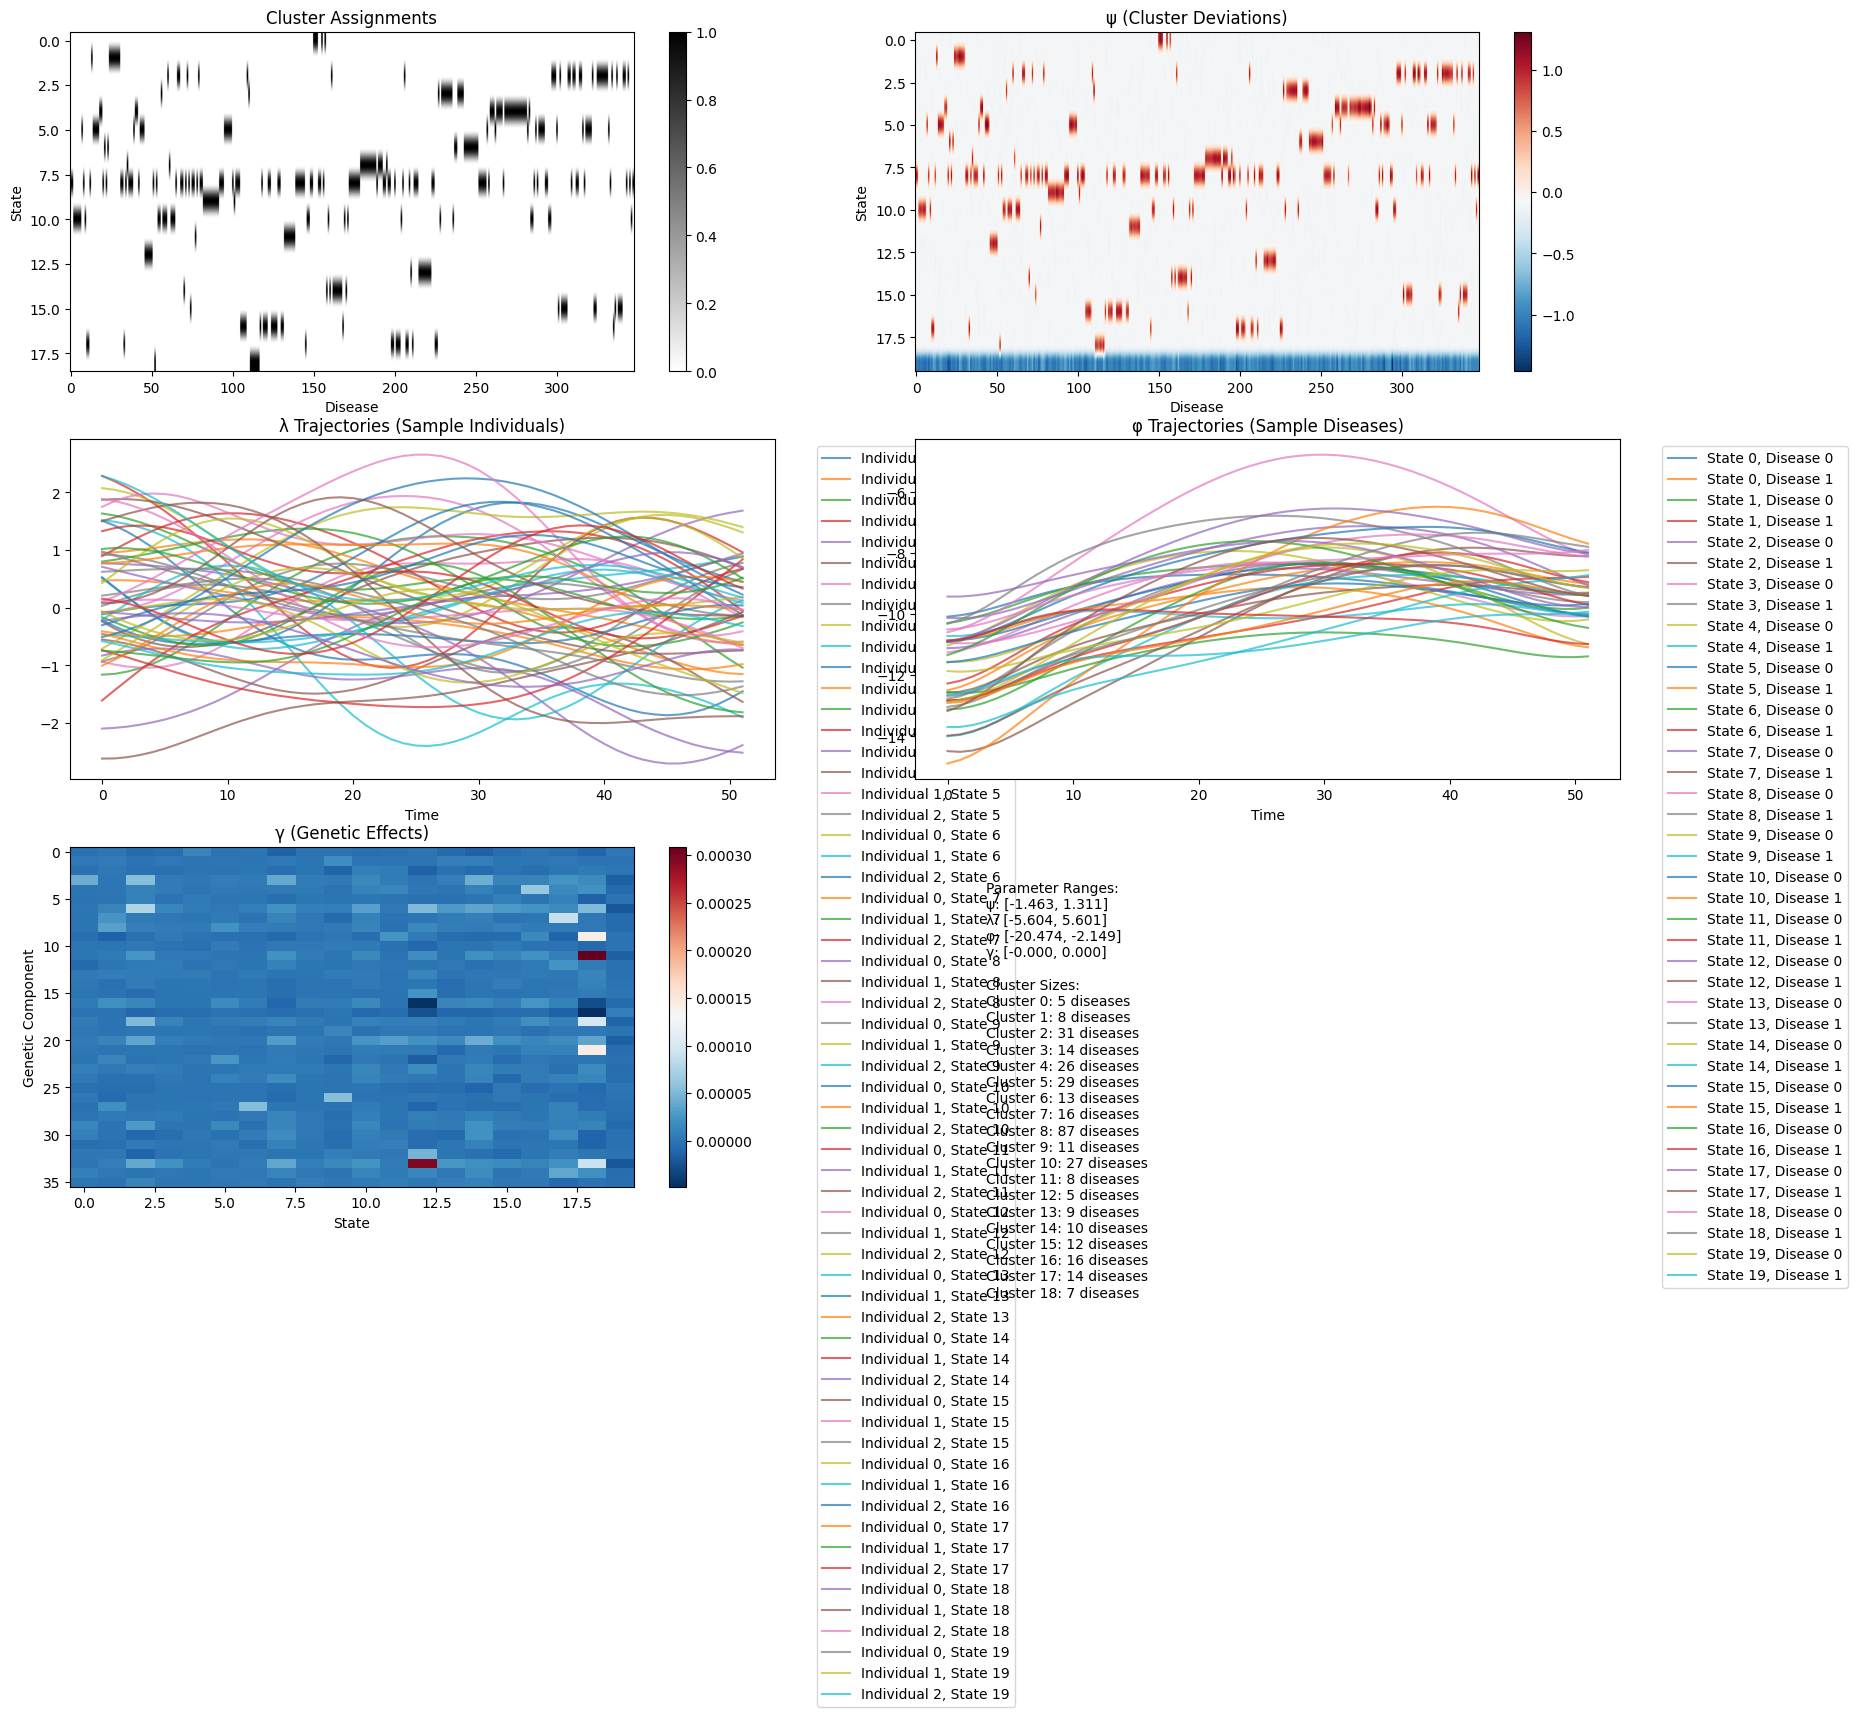

PSI values: Parameter containing:
tensor([[-0.0932, -0.1011, -0.0994,  ..., -0.0901, -0.1163, -0.1074],
        [-0.0814, -0.1275, -0.1129,  ..., -0.0887, -0.1130, -0.0973],
        [-0.1036, -0.0746, -0.1033,  ..., -0.0984, -0.0744, -0.0990],
        ...,
        [-0.1008, -0.1073, -0.0933,  ..., -0.1105, -0.0963, -0.0855],
        [-0.0841, -0.1066, -0.0815,  ..., -0.0955, -0.0954, -0.1168],
        [-1.1157, -1.0394, -1.1218,  ..., -0.9750, -0.9908, -0.9384]],
       requires_grad=True)


In [18]:
import torch

def load_saved_model(model_path='/Users/sarahurbut/aladynoulli/pyScripts/trained_model.pt'):
    """
    Load a previously saved model and all its components
    """
    print("Loading saved model...")
    model_state = torch.load(model_path)
    
    # Extract components
    Y_tensor = model_state['Y_tensor']
    disease_names = model_state['disease_names']
    clusters = model_state['clusters']
    psi = model_state['psi']
    
    print(f"Loaded model with:")
    print(f"- {len(disease_names)} diseases")
    print(f"- {len(clusters)} clusters")
    
    # Recreate model
    model = AladynSurvivalFixedKernelsAvgLoss_clust(
        N=Y_tensor.shape[0],
        D=Y_tensor.shape[1],
        T=Y_tensor.shape[2],
        K=20,
        P=P,
        G=G,
        Y=Y_tensor,
        prevalence_t=prevalence_t
    )
    
    # Load saved state
    model.load_state_dict(model_state['model_state'])
    model.clusters = clusters
    model.psi = psi
    
    return model, Y_tensor, disease_names

# Load and visualize
model, Y_tensor, disease_names = load_saved_model()
model.visualize_clusters(disease_names)
model.visualize_initialization()
print("PSI values:", model.psi)

In [21]:
import numpy as np
import torch

# Save G
def save_G(G, path='/Users/sarahurbut/aladynoulli/pyScripts/G_matrix.pt'):
    """
    Save G matrix for quick loading
    """
    # Convert to PyTorch tensor if it's not already
    if not isinstance(G, torch.Tensor):
        G = torch.FloatTensor(G)
    
    # Save
    torch.save(G, path)
    print(f"Saved G matrix of shape {G.shape} to {path}")

# Load G
def load_G(path='/Users/sarahurbut/aladynoulli/pyScripts/G_matrix.pt'):
    """
    Load G matrix quickly
    """
    G = torch.load(path)
    print(f"Loaded G matrix of shape {G.shape}")
    return G

# Usage:
# First time: save G
save_G(G)


Saved G matrix of shape torch.Size([407878, 36]) to /Users/sarahurbut/aladynoulli/pyScripts/G_matrix.pt


In [25]:

import numpy as np
import torch

def save_matrices(G, E, base_path='/Users/sarahurbut/aladynoulli/pyScripts/'):
    """
    Save both G and E matrices for quick loading
    """
    # Save G
    g_path = base_path + 'G_matrix.pt'
    if not isinstance(G, torch.Tensor):
        G = torch.FloatTensor(G)
    torch.save(G, g_path)
    print(f"Saved G matrix of shape {G.shape}")
    
    # Save E
    e_path = base_path + 'E_matrix.pt'
    if not isinstance(E, torch.Tensor):
        E = torch.FloatTensor(E)
    torch.save(E, e_path)
    print(f"Saved E matrix of shape {E.shape}")

In [27]:
save_matrices(G, E)

Saved G matrix of shape torch.Size([407878, 36])
Saved E matrix of shape torch.Size([407878, 348])


In [32]:
def load_matrices(base_path='/Users/sarahurbut/Dropbox (Personal)/'):
    """
    Load both G and E matrices quickly
    """
    # Load G
    G = torch.load(base_path + 'G_matrix.pt')
    print(f"Loaded G matrix of shape {G.shape}")
    
    # Load E
    E = torch.load(base_path + 'E_matrix.pt')
    print(f"Loaded E matrix of shape {E.shape}")
    
    return G, E

In [33]:
G, E = load_matrices()

Loaded G matrix of shape torch.Size([407878, 36])
Loaded E matrix of shape torch.Size([407878, 348])


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_98999/1866454604.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G = torch.load(base_path + 'G_matrix.pt')
/va

In [35]:
G.shape

torch.Size([407878, 36])

In [44]:
Y_tensor.shape

torch.Size([407878, 348, 52])

In [38]:
import torch
import numpy as np

def save_all_components(model, G, E, disease_names, base_path='/Users/sarahurbut/aladynoulli/pyScripts/'):
    """
    Save all necessary components for running the model
    """
    print("Saving all components...")
    
    # 1. Save model components (without full Y tensor)
    model_components = {
        'clusters': model.clusters,
        'psi': model.psi,
        'disease_names': disease_names,
        'model_state': model.state_dict()
    }
    torch.save(model_components, base_path + 'model_components.pt')
    
    # 2. Save G and E matrices
    np.savez(base_path + 'GE_matrices.npz', G=G.cpu().numpy(), E=E.cpu().numpy())
    
    print("Saved all components successfully!")

def load_all_components(base_path='/Users/sarahurbut/aladynoulli/pyScripts/'):
    """
    Load all necessary components efficiently
    """
    import gc
    print("Loading components...")
    
    # 1. Load model components
    model_data = torch.load(base_path + 'model_components.pt')
    
    # 2. Load matrices
    matrices = np.load(base_path + 'GE_matrices.npz')
    G = torch.FloatTensor(matrices['G'])
    E = torch.FloatTensor(matrices['E'])
    
    # Clear some memory
    del matrices
    gc.collect()
    
    return {
        'G': G,
        'E': E,
        'clusters': model_data['clusters'],
        'psi': model_data['psi'],
        'disease_names': model_data['disease_names'],
        'model_state': model_data['model_state']
    }

# Save everything:
save_all_components(model, G, E, disease_names)

# Load and use:
def run_visualization():
    """
    Load and visualize model results
    """
    # Load components
    data = load_all_components()
    
    # Print cluster information
    print("\nCluster Sizes:")
    for k in range(19):
        size = sum(data['clusters'] == k)
        diseases = [data['disease_names'][i] 
                   for i in range(len(data['clusters'])) 
                   if data['clusters'][i] == k]
        print(f"\nCluster {k}: {size} diseases")
        print("Diseases:", diseases)
    
    print("\nPSI values:")
    print(data['psi'])
    
    return data

# Usage:


Saving all components...
Saved all components successfully!


In [39]:
data = run_visualization()

Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_98999/2961784643.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(base_path + 'model_c


Cluster Sizes:

Cluster 0: 5 diseases
Diseases: ['Septal Deviations/Turbinate Hypertrophy', 'Nasal polyps', 'Chronic pharyngitis and nasopharyngitis', 'Chronic sinusitis', 'Other upper respiratory disease']

Cluster 1: 8 diseases
Diseases: ['Cancer of bronchus; lung', 'Malignant neoplasm, other', 'Secondary malignant neoplasm', 'Secondary malignancy of lymph nodes', 'Secondary malignancy of respiratory organs', 'Secondary malignant neoplasm of digestive systems', 'Secondary malignant neoplasm of liver', 'Secondary malignancy of bone']

Cluster 2: 31 diseases
Diseases: ['Obesity', 'Major depressive disorder', 'Anxiety disorder', 'Sleep apnea', 'Other peripheral nerve disorders', 'Essential hypertension', 'Asthma', 'Irritable Bowel Syndrome', 'Rheumatoid arthritis', 'Other inflammatory spondylopathies', 'Arthropathy NOS', 'Spondylosis and allied disorders', 'Peripheral enthesopathies and allied syndromes', 'Enthesopathy', 'Other disorders of synovium, tendon, and bursa', 'Synovitis and 

In [43]:
def initialize_from_saved(base_path='/Users/sarahurbut/aladynoulli/pyScripts/'):
    """
    Load saved components and initialize model for visualization
    """
    print("Loading saved components...")
    data = load_all_components(base_path)
    
    # Create dummy Y and prevalence tensors (small, just for initialization)
    N = data['E'].shape[0]
    D = data['E'].shape[1]
    dummy_Y = torch.zeros((N, D, 50), dtype=torch.float32)
    dummy_prevalence = torch.zeros((D, 50), dtype=torch.float32)
    
    # Initialize model
    model = AladynSurvivalFixedKernelsAvgLoss_clust(
        N=N,
        D=D,
        T=50,
        K=19,
        P=data['G'].shape[1],
        G=data['G'],
        Y=dummy_Y,              # Use dummy Y
        prevalence_t=dummy_prevalence  # Use dummy prevalence
    )
    
    # Load saved state
    model.load_state_dict(data['model_state'])
    model.clusters = data['clusters']
    model.psi = data['psi']
    
    print("\nModel initialized with:")
    print(f"- {len(data['disease_names'])} diseases")
    print(f"- {len(set(data['clusters']))} clusters")
    
    # Run visualizations
    print("\nVisualizing clusters...")
    model.visualize_clusters(data['disease_names'])
    print("\nVisualizing initialization...")
    model.visualize_initialization()
    
    return model, data

# Usage:
model, data = initialize_from_saved()

Loading saved components...
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_98999/2961784643.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(base_path + 'model_c

Lambda kernel condition number: 45214952.00
Phi kernel condition number: 104912536.00


ValueError: Input X contains NaN.
SpectralClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [42]:
def initialize_from_saved(base_path='/Users/sarahurbut/aladynoulli/pyScripts/'):
    """
    Load saved components and initialize model
    """
    print("Loading saved components...")
    data = load_all_components(base_path)
    
    # Initialize model with saved parameters
    model = AladynSurvivalFixedKernelsAvgLoss_clust(
        N=data['E'].shape[0],  # number of patients from E
        D=data['E'].shape[1],  # number of diseases from E
        T=50,                  # number of timepoints
        K=19,                  # number of clusters
        P=data['G'].shape[1],  # number of PCs from G
        G=data['G'],
        Y=None,               # we don't need Y for visualization
        prevalence_t=None     # we don't need prevalence for visualization
    )
    
    # Load saved state
    model.load_state_dict(data['model_state'])
    model.clusters = data['clusters']
    model.psi = data['psi']
    
    print("\nModel initialized with:")
    print(f"- {len(data['disease_names'])} diseases")
    print(f"- {len(set(data['clusters']))} clusters")
    
    # Run visualizations
    print("\nVisualizing clusters...")
    model.visualize_clusters(data['disease_names'])
    print("\nVisualizing initialization...")
    model.visualize_initialization()
    
    return model, data

# Usage:
model, data = initialize_from_saved()

Loading saved components...
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_98999/2961784643.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(base_path + 'model_c

TypeError: must be real number, not NoneType

In [57]:
# Store initial psi values
initial_psi = model.psi.detach().clone()


history = model.fit(E, num_epochs=10, learning_rate=1e-4, lambda_reg=1e-2)

# Compare final vs initial psi
print("\nOverall psi changes:")

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


: 

In [ ]:
import torch


def load_saved_model(model_path='/Users/sarahurbut/aladynoulli/pyScripts/trained_model.pt'):
    """
    Load a previously saved model and all its components
    """
    print("Loading saved model...")
    model_state = torch.load(model_path)
    
    # Extract components
    Y_tensor = model_state['Y_tensor']
    disease_names = model_state['disease_names']
    clusters = model_state['clusters']
    psi = model_state['psi']
    
    print(f"Loaded model with:")
    print(f"- {len(disease_names)} diseases")
    print(f"- {len(clusters)} clusters")
    
    # Recreate model
    model = AladynSurvivalFixedKernelsAvgLoss_clust(
        N=Y_tensor.shape[0],
        D=Y_tensor.shape[1],
        T=Y_tensor.shape[2],
        K=19,
        P=P,
        G=G,
        Y=Y_tensor,
        prevalence_t=prevalence_t
    )
    
    # Load saved state
    model.load_state_dict(model_state['model_state'])
    model.clusters = clusters
    model.psi = psi
    
    return model, Y_tensor, disease_names

# Load and visualize
model, Y_tensor, disease_names = load_saved_model()
model.visualize_clusters(disease_names)
model.visualize_initialization()
print("PSI values:", model.psi)

In [2]:
def process_data_efficiently():
    """
    Efficient data processing strategy
    """
    # 1. First, let's analyze memory usage
    print("Checking available memory...")
    import psutil
    available_memory = psutil.virtual_memory().available / 1e9  # in GB
    print(f"Available memory: {available_memory:.1f} GB")
    
    # 2. Calculate required memory
    N, D, T = 500000, 348, 50
    tensor_size = N * D * T * 4 / 1e9  # 4 bytes per float32, convert to GB
    print(f"Required tensor size: {tensor_size:.1f} GB")
    
    if tensor_size > available_memory * 0.8:  # Leave 20% memory buffer
        print("Using chunk processing...")
        # Calculate optimal chunk size
        chunk_size = int((available_memory * 0.4 * 1e9) / (D * T * 4))
        chunk_size = min(chunk_size, 50000)  # Cap at 50k patients
        
        return load_sparse_in_chunks(chunk_size=chunk_size)
    else:
        print("Loading full tensor...")
        return convert_to_sparse_tensor()

# Let's try it
try:
    data = process_data_efficiently()
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error: {e}")

Checking available memory...
Available memory: 82.8 GB
Required tensor size: 34.8 GB
Loading full tensor...
Error: name 'convert_to_sparse_tensor' is not defined


In [ ]:
# Store initial psi values
initial_psi = model.psi.detach().clone()

# Run a few iterations
for i in range(5):  # Try just 5 iterations
    model.zero_grad()
    loss = model.compute_loss(E_tensor)
    loss.backward()
    
    # Print gradient info
    print(f"\nIteration {i}")
    print(f"Loss: {loss.item():.4f}")
    print(f"Psi grad mean: {model.psi.grad.mean().item():.4f}")
    print(f"Psi grad std: {model.psi.grad.std().item():.4f}")
    
    # Update parameters
    optimizer = torch.optim.Adam([model.psi, model.phi, model.lambda_, model.gamma], lr=1e-3)
    optimizer.step()

# Compare initial and final psi values
print("\nPsi changes:")
print("Max absolute change:", (model.psi - initial_psi).abs().max().item())
print("Mean absolute change:", (model.psi - initial_psi).abs().mean().item())

# Look at a few specific values
print("\nSample psi values before/after:")
for k in range(2):  # Look at first two states
    for d in range(3):  # Look at first three diseases
        print(f"State {k}, Disease {d}:")
        print(f"  Before: {initial_psi[k,d]:.4f}")
        print(f"  After:  {model.psi[k,d].item():.4f}")

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Create masks for events and censoring



Iteration 0
Loss: 992.9323
Psi grad mean: 0.0000
Psi grad std: 0.0043

Iteration 1
Loss: 972.4259
Psi grad mean: 0.0000
Psi grad std: 0.0043

Iteration 2
Loss: 952.3469
Psi grad mean: 0.0000
Psi grad std: 0.0043


In [41]:
# Store initial psi

# Run test with 5 iterations to see larger changes
initial_psi = model.psi.detach().clone()

for i in range(5):
    optimizer.zero_grad()
    loss = model.compute_loss(E_tensor)
    loss.backward()
    optimizer.step()
    
    # Print changes after each iteration
    changes = (model.psi - initial_psi).abs()
    print(f"\nIteration {i+1}")
    print(f"Max change: {changes.max().item():.6f}")
    print(f"Avg change: {changes.mean().item():.6f}")
    
    # Print cluster-specific changes
    for k in range(model.K-1):  # For each cluster (excluding background)
        cluster_mask = (model.clusters == k)
        in_cluster = changes[k, cluster_mask].mean().item()
        out_cluster = changes[k, ~cluster_mask].mean().item()
        print(f"\nCluster {k}:")
        print(f"In-cluster change:  {in_cluster:.6f}")
        print(f"Out-cluster change: {out_cluster:.6f}")

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Create masks for events and censoring



Iteration 1
Max change: 0.001021
Avg change: 0.000988

Cluster 0:
In-cluster change:  0.000994
Out-cluster change: 0.000993

Cluster 1:
In-cluster change:  0.000998
Out-cluster change: 0.000989

Cluster 2:
In-cluster change:  0.000985
Out-cluster change: 0.000980

Cluster 3:
In-cluster change:  0.000992
Out-cluster change: 0.000985

Cluster 4:
In-cluster change:  0.000993
Out-cluster change: 0.000992

Cluster 5:
In-cluster change:  0.000999
Out-cluster change: 0.000988

Cluster 6:
In-cluster change:  0.000997
Out-cluster change: 0.000988

Cluster 7:
In-cluster change:  0.000999
Out-cluster change: 0.000984

Cluster 8:
In-cluster change:  0.000988
Out-cluster change: 0.000995

Cluster 9:
In-cluster change:  0.000999
Out-cluster change: 0.000983

Cluster 10:
In-cluster change:  0.000999
Out-cluster change: 0.000987

Cluster 11:
In-cluster change:  0.000999
Out-cluster change: 0.000979

Cluster 12:
In-cluster change:  0.000999
Out-cluster change: 0.000994

Cluster 13:
In-cluster change: 

In [13]:
history = model.fit(event_times=E_tensor, 
                   num_epochs=1000, 
                   learning_rate=1e-3)

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


Epoch 0, Loss: 1102.9111, Gradients - Lambda: 8.741e-03, Phi: 1.649e-01, Gamma: 5.932e-02, Psi: 1.724e-02
Epoch 1, Loss: 1080.2479, Gradients - Lambda: 8.698e-03, Phi: 1.644e-01, Gamma: 5.618e-02, Psi: 3.449e-02

Estimated total training time: 16549.2 minutes
Epoch 2, Loss: 1058.0497, Gradients - Lambda: 8.654e-03, Phi: 1.639e-01, Gamma: 5.316e-02, Psi: 5.173e-02
Epoch 3, Loss: 1036.3042, Gradients - Lambda: 8.611e-03, Phi: 1.633e-01, Gamma: 5.018e-02, Psi: 6.897e-02
Epoch 4, Loss: 1015.0310, Gradients - Lambda: 8.568e-03, Phi: 1.628e-01, Gamma: 4.732e-02, Psi: 8.622e-02
Epoch 5, Loss: 994.2011, Gradients - Lambda: 8.525e-03, Phi: 1.622e-01, Gamma: 4.462e-02, Psi: 1.035e-01
Epoch 6, Loss: 973.8411, Gradients - Lambda: 8.482e-03, Phi: 1.617e-01, Gamma: 4.204e-02, Psi: 1.207e-01
Epoch 7, Loss: 953.9355, Gradients - Lambda: 8.439e-03, Phi: 1.611e-01, Gamma: 3.955e-02, Psi: 1.380e-01
Epoch 8, Loss: 934.4704, Gradients - Lambda: 8.395e-03, Phi: 1.606e-01, Gamma: 3.713e-02, Psi: 1.552e-01
Ep

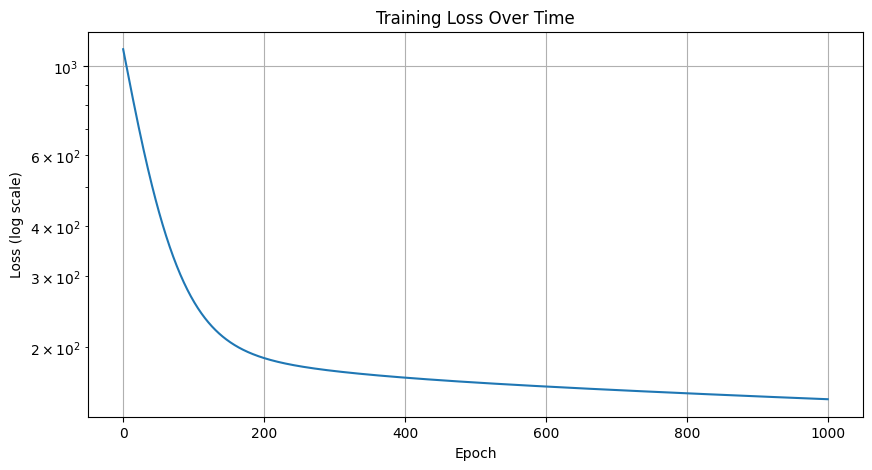

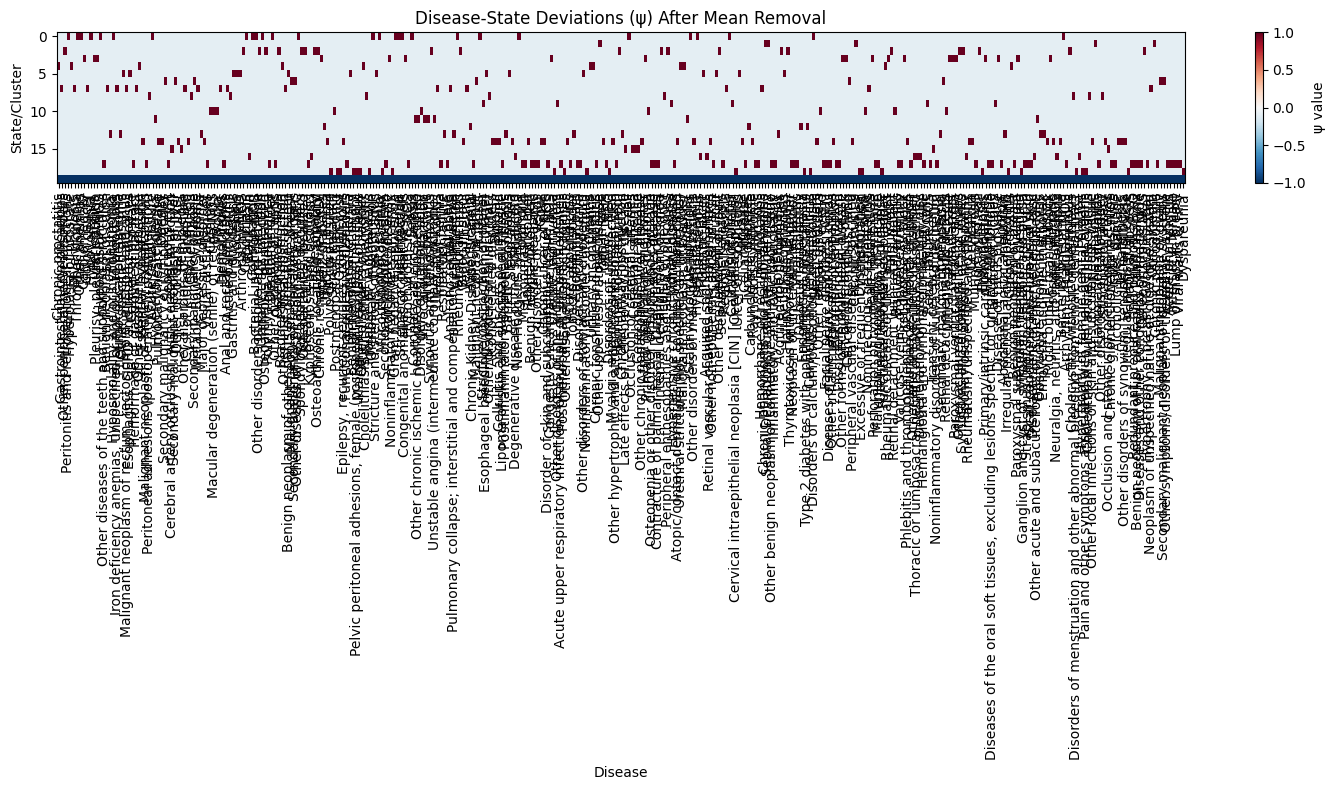


Psi Statistics:
Mean: -0.090
Std: 0.318
Min: -1.000
Max: 1.000

Top diseases in State 0:
Hyposmolality and/or hyponatremia: 1.000
Gram negative septicemia: 1.000
Hyperpotassemia: 1.000
Decubitus ulcer: 1.000
Staphylococcus infections: 1.000

Top diseases in State 1:
Chronic sinusitis: 1.000
Nasal polyps: 1.000
Other upper respiratory disease: 1.000
Chronic pharyngitis and nasopharyngitis: 1.000
Septal Deviations/Turbinate Hypertrophy: 1.000

Top diseases in State 2:
Hammer toe (acquired): 1.000
Enthesopathy: 1.000
Symptoms and disorders of the joints: 1.000
Osteoporosis NOS: 1.000
Hallux rigidus: 1.000

Top diseases in State 3:
Chronic renal failure [CKD]: 1.000
Pleurisy; pleural effusion: 1.000
Heart failure NOS: 1.000
Disease of tricuspid valve: 1.000
Right bundle branch block: 1.000

Top diseases in State 4:
Chronic prostatitis: 1.000
Cystitis: 1.000
Chronic cystitis: 1.000
Other disorders of prostate: 1.000
Malignant neoplasm of bladder: 1.000

Top diseases in State 5:
Reflux esop

In [14]:
# Plot training loss history
plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.yscale('log')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.grid(True)
plt.show()

# Visualize psi map
plt.figure(figsize=(15, 8))
psi_np = model.psi.detach().numpy()
plt.imshow(psi_np, aspect='auto', cmap='RdBu_r')
plt.colorbar(label='ψ value')
plt.xlabel('Disease')
plt.ylabel('State/Cluster')
plt.title('Disease-State Deviations (ψ) After Mean Removal')

# If you have disease names, add them as x-axis labels
if disease_names_list:
    plt.xticks(range(len(disease_names_list)), disease_names_list, rotation=90)

plt.tight_layout()
plt.show()

# Print some summary statistics about psi
print("\nPsi Statistics:")
print(f"Mean: {psi_np.mean():.3f}")
print(f"Std: {psi_np.std():.3f}")
print(f"Min: {psi_np.min():.3f}")
print(f"Max: {psi_np.max():.3f}")

# Optionally, identify the strongest associations
n_top = 5  # Number of top associations to show
for k in range(psi_np.shape[0]):  # For each state/cluster
    top_indices = np.argsort(np.abs(psi_np[k]))[-n_top:]
    print(f"\nTop diseases in State {k}:")
    for idx in top_indices[::-1]:
        disease_name = disease_names_list[idx] if disease_names_list else f"Disease {idx}"
        print(f"{disease_name}: {psi_np[k, idx]:.3f}")

In [19]:
psi_np = model.psi.detach().numpy()

# Print basic info about psi matrix
print("Psi matrix shape:", psi_np.shape)
print("\nPsi value ranges:")
print(f"Min: {psi_np.min():.3f}")
print(f"Max: {psi_np.max():.3f}")
print(f"Mean: {psi_np.mean():.3f}")
print(f"Std: {psi_np.std():.3f}")

# Look at a small sample of values
print("\nSample of psi values (first 5 states, first 5 diseases):")
print(psi_np[:5, :5])

Psi matrix shape: (20, 348)

Psi value ranges:
Min: -1.000
Max: 1.000
Mean: -0.090
Std: 0.318

Sample of psi values (first 5 states, first 5 diseases):
[[-0.1 -0.1 -0.1  1.  -0.1]
 [-0.1 -0.1 -0.1 -0.1 -0.1]
 [-0.1 -0.1  1.  -0.1 -0.1]
 [-0.1 -0.1 -0.1 -0.1 -0.1]
 [ 1.  -0.1 -0.1 -0.1  1. ]]


In [21]:
# 1. Verify psi requires gradient
print("Psi requires gradient:", model.psi.requires_grad)

# 2. Look at gradient values after a forward pass
model.zero_grad()
# Call forward method correctly using the model directly
loss = model(E_tensor)  # This calls forward() internally
loss.backward()
print("\nPsi gradient stats:")
print("Gradient mean:", model.psi.grad.mean().item())
print("Gradient std:", model.psi.grad.std().item())
print("Gradient min:", model.psi.grad.min().item())
print("Gradient max:", model.psi.grad.max().item())

# 3. Let's also look at the optimizer parameters
print("\nOptimizer state:")
for param_group in model.optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Parameters being optimized:", [p.shape for p in param_group['params']])

Psi requires gradient: True


TypeError: forward() takes 1 positional argument but 2 were given

In [ ]:
from gp_diffscales_withavgloss_fixkernel_trueavg import *
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernelsAvgLoss(
    N=N, D=D, T=T, K=K, P=P,
    G=G,
    Y=Y,
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

In [44]:

import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_97896/848081885.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


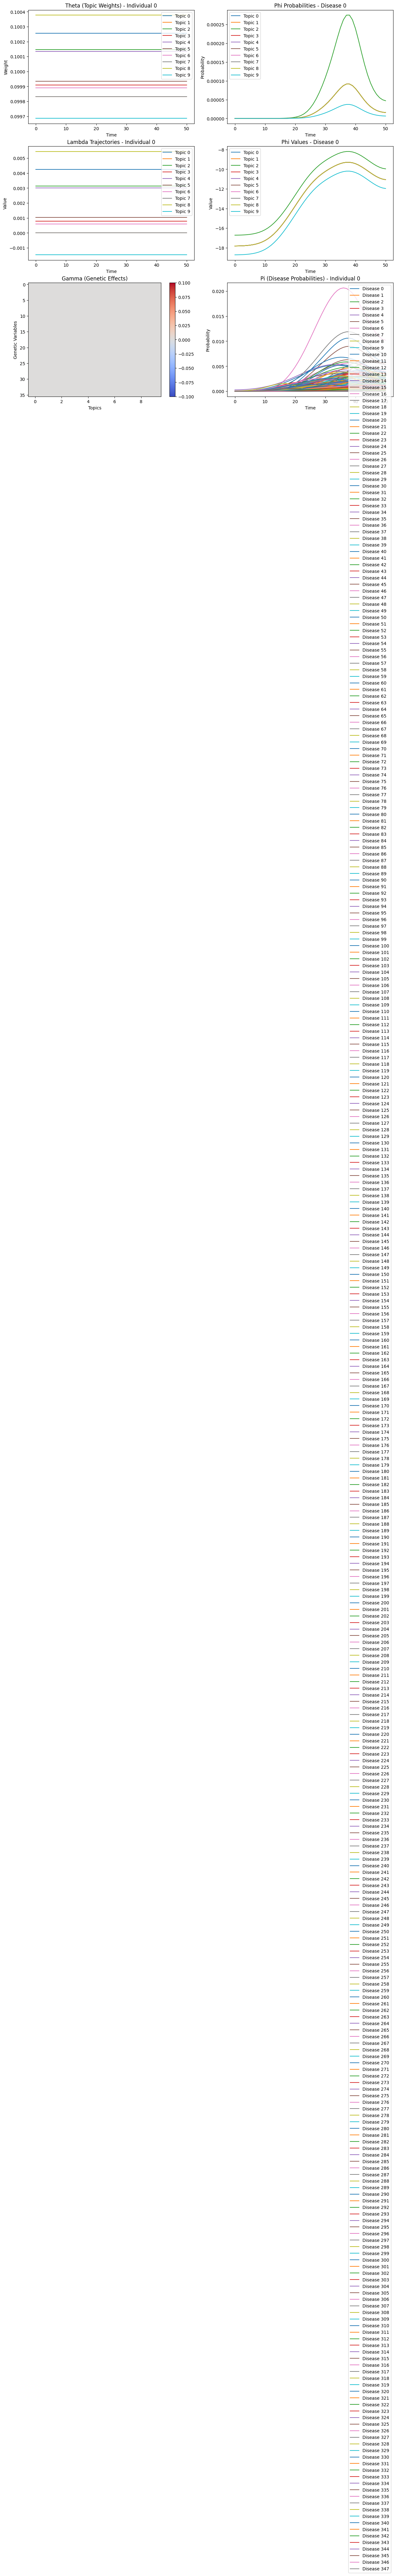

In [45]:

K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()




In [ ]:
def evaluate_event_prediction(model, Y, E):
    """
    Evaluate how well the model predicts events
    """
    # Get predictions and convert everything to numpy
    pi_pred, _, _ = model.forward()
    pi_np = pi_pred.detach().numpy()
    Y_np = Y.detach().numpy()
    E_np = E.detach().numpy().astype(int)  # Convert to integer indices
    
    # Get probabilities at event times
    event_probs = []
    non_event_probs = []
    
    N, D, _ = Y_np.shape
    
    for i in range(N):
        for d in range(D):
            event_time = int(E_np[i,d])  # Ensure integer index
            try:
                if Y_np[i,d,event_time] == 1:  # If there's an event
                    event_probs.append(pi_np[i,d,event_time])
                else:
                    non_event_probs.append(pi_np[i,d,event_time])
            except IndexError:
                print(f"Warning: Index error at i={i}, d={d}, t={event_time}")
                continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    if event_probs:  # Only plot if we have events
        plt.hist(event_probs, alpha=0.5, label='Event probabilities', 
                density=True, bins=30, color='blue')
    if non_event_probs:  # Only plot if we have non-events
        plt.hist(non_event_probs, alpha=0.5, label='Non-event probabilities', 
                density=True, bins=30, color='red')
    
    plt.title('Distribution of Predicted Probabilities at Event Times')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Print summary statistics
    if event_probs:
        print(f"Mean probability at events: {np.mean(event_probs):.3f}")
        print(f"Number of events: {len(event_probs)}")
    if non_event_probs:
        print(f"Mean probability at non-events: {np.mean(non_event_probs):.3f}")
        print(f"Number of non-events: {len(non_event_probs)}")

# Use the function
evaluate_event_prediction(model, Y_tensor, E_tensor)

In [ ]:
# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()
disease_names_list = disease_names[0].tolist()

prs_names_list = prs_names[0].tolist()
def plot_phi_heatmaps_with_labels(phi_pred, K, D, T, disease_names, n_top=20):
    """
    Plot heatmaps of phi values for each topic, showing top n diseases based on their importance to the topic.
    
    Parameters:
    phi_pred: predicted phi values (K x D x T)
    K: number of topics
    D: number of diseases
    T: number of timepoints
    disease_names: list of disease names
    n_top: number of top diseases to show per topic
    """
    phi_np = phi_pred.detach().numpy()
    
    fig, axes = plt.subplots(K, 1, figsize=(15, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        # Find top n diseases for this topic based on maximum absolute values
        #topic_max = np.max(np.abs(phi_np[k]), axis=1) 
        topic_max = np.mean(phi_np[k], axis=1)  # Max across time for each disease
        top_indices = np.argsort(topic_max)[-n_top:][::-1]  # Get indices of top n diseases
        
        # Get the data for just these top diseases
        top_data = phi_np[k, top_indices]
        
        # Plot the data
        im = axes[k].imshow(top_data, aspect='auto', cmap='RdBu_r')
        plt.colorbar(im, ax=axes[k])
        
        axes[k].set_title(f'Topic {k} - Top {n_top} Disease Patterns')
        axes[k].set_xlabel('Time')
        axes[k].set_ylabel('Disease')
        
        # Use disease names for top diseases only
        axes[k].set_yticks(range(n_top))
        disease_labels = [f"{disease_names[i]} (max={topic_max[i]:.3f})" 
                         for i in top_indices]
        axes[k].set_yticklabels(disease_labels)
        
        time_ticks = np.linspace(0, T-1, 5, dtype=int)
        axes[k].set_xticks(time_ticks)
        axes[k].set_xticklabels(time_ticks)
        
        # Add grid for better readability
        axes[k].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Return top indices for each topic
    top_indices_per_topic = [np.argsort(np.max(np.abs(phi_np[k]), axis=1))[-n_top:][::-1] 
                            for k in range(K)]
    return top_indices_per_topic

# Usage:
top_indices = plot_phi_heatmaps_with_labels(
    phi_pred, K, D, T, disease_names_list, n_top=20
)

In [ ]:
disease_names

In [ ]:
def analyze_disease_clusters(Y, disease_names, n_clusters=10, min_prevalence=0.01, output_pdf="disease_clusters.pdf"):
    """
    Analyze disease clusters based on co-occurrence patterns and save to PDF
    
    Parameters:
    Y: disease occurrence array (N x D x T)
    disease_names: list of disease names
    n_clusters: number of desired clusters
    min_prevalence: minimum disease prevalence to include
    output_pdf: path to save the PDF output
    """
    import numpy as np
    from sklearn.cluster import SpectralClustering
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage
    from matplotlib.backends.backend_pdf import PdfPages
    
    # Create PDF
    pdf = PdfPages(output_pdf)
    
    # Convert to binary occurrence matrix
    Y_any = (np.sum(Y, axis=2) > 0).astype(float)  # N x D
    
    # Calculate disease prevalence
    prevalence = Y_any.mean(axis=0)
    
    # Filter rare diseases
    common_diseases = prevalence >= min_prevalence
    Y_filtered = Y_any[:, common_diseases]
    names_filtered = [name for name, keep in zip(disease_names, common_diseases) if keep]
    
    # Compute co-occurrence matrix
    cooc = Y_filtered.T @ Y_filtered  # D x D
    
    # Normalize by prevalence to get phi coefficient
    prev_matrix = prevalence[common_diseases][:, None] @ prevalence[common_diseases][None, :]
    cooc_norm = (cooc / Y_filtered.shape[0] - prev_matrix) / np.sqrt(
        prev_matrix * (1 - prev_matrix) + 1e-8)
    
    # Set diagonal to 0
    np.fill_diagonal(cooc_norm, 0)
    
    # Perform clustering
    clustering = SpectralClustering(n_clusters=n_clusters, 
                                  affinity='precomputed',
                                  random_state=42)
    
    # Convert to similarity matrix
    similarity = np.exp(cooc_norm)
    clusters = clustering.fit_predict(similarity)
    
    # 1. Hierarchical clustering visualization
    plt.figure(figsize=(20, 15))
    linkage_matrix = linkage(cooc_norm, method='ward')
    dendrogram(linkage_matrix, labels=names_filtered, leaf_rotation=90)
    plt.title('Hierarchical Clustering of Diseases')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 2. Correlation heatmap with cluster boundaries
    plt.figure(figsize=(20, 15))
    # Sort by cluster
    cluster_order = np.argsort(clusters)
    cooc_sorted = cooc_norm[cluster_order][:, cluster_order]
    names_sorted = [names_filtered[i] for i in cluster_order]
    
    sns.heatmap(cooc_sorted, xticklabels=names_sorted, yticklabels=names_sorted)
    plt.title('Disease Co-occurrence Pattern (Sorted by Cluster)')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 3. Create a text page with cluster contents
    plt.figure(figsize=(20, 15))
    plt.axis('off')
    text_content = "Disease Clusters:\n\n"
    
    for k in range(n_clusters):
        cluster_diseases = [names_filtered[i] for i in range(len(clusters)) if clusters[i] == k]
        text_content += f"\nCluster {k+1}:\n"
        for disease in cluster_diseases:
            prev = prevalence[disease_names.index(disease)]
            text_content += f"  - {disease} (prevalence: {prev:.3f})\n"
    
    plt.text(0.1, 0.9, text_content, fontsize=12, verticalalignment='top')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # Close PDF
    pdf.close()
    
    print(f"Analysis saved to {output_pdf}")
    return clusters, common_diseases

# Use the function
clusters, common_diseases = analyze_disease_clusters(Y, disease_names_list, 
                                                   n_clusters=K, 
                                                   output_pdf="disease_clusters.pdf")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Y (N x D x T) and G (N x P) are your data
# and disease_names is your list of disease names

def test_initialization(Y, G, K=10, disease_names=None):
    """
    Test factor initialization and visualize results
    """
    N, D, T = Y.shape
    
    # Convert to torch tensors if needed
    Y = torch.tensor(Y, dtype=torch.float32)
    G = torch.tensor(G, dtype=torch.float32)
    
    # Compute average disease occurrence
    Y_avg = torch.mean(Y, dim=2)  # N x D
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = torch.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    
    # Center the logit-transformed data
    disease_means = torch.mean(Y_logit, dim=0)
    Y_centered = Y_logit - disease_means[None, :]
    
    # Perform SVD
    U, S, Vh = torch.linalg.svd(Y_centered, full_matrices=False)
    
    # Initialize lambda and phi
    lambda_init = U[:, :K] @ torch.diag(torch.sqrt(S[:K]))
    gamma_init = torch.linalg.lstsq(G, lambda_init).solution
    phi_base = Vh[:K, :].T * torch.sqrt(S[:K])  # D x K
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # 1. Plot singular values
    plt.subplot(2, 2, 1)
    plt.plot(S.numpy(), 'o-')
    plt.title('Singular Values')
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    
    # 2. Plot disease loadings heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(phi_base.numpy(), 
                xticklabels=[f'Factor {i+1}' for i in range(K)],
                yticklabels=disease_names if disease_names else None)
    plt.title('Disease Loadings (Phi)')
    
    # 3. Print top diseases for each factor
    plt.figure(figsize=(15, 10))
    n_top = 10  # number of top diseases to show
    
    for k in range(min(K, 10)):  # Show first 6 factors
        plt.subplot(3, 4, k+1)
        
        # Get top diseases for this factor
        factor_loadings = phi_base[:, k].numpy()
        top_idx = np.argsort(np.abs(factor_loadings))[-n_top:]
        
        # Plot bar chart
        plt.barh(range(n_top), factor_loadings[top_idx])
        plt.yticks(range(n_top), 
                  [disease_names[i] if disease_names else f"Disease {i}" 
                   for i in top_idx])
        plt.title(f'Factor {k+1} Top Diseases')
    
    plt.tight_layout()
    
    # Print some statistics
    print("\nInitialization Statistics:")
    print(f"Lambda scale: mean={lambda_init.mean():.3f}, std={lambda_init.std():.3f}")
    print(f"Gamma scale: mean={gamma_init.mean():.3f}, std={gamma_init.std():.3f}")
    print(f"Phi scale: mean={phi_base.mean():.3f}, std={phi_base.std():.3f}")
    
    return lambda_init, gamma_init, phi_base, S

# Run the test
lambda_init, gamma_init, phi_base, S = test_initialization(Y, G, K=10, disease_names=disease_names_list)

In [79]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [81]:

def varimax_rotation(loadings, max_iter=1000, tol=1e-6):
    """Apply varimax rotation to loadings matrix"""
    n_rows, n_cols = loadings.shape
    rotation = np.eye(n_cols)
    
    var_old = 0
    for _ in range(max_iter):
        basis = loadings @ rotation
        h = basis ** 2
        mu = h.mean(axis=0, keepdims=True)
        term1 = basis ** 3
        term2 = basis @ np.diag(mu.squeeze())
        u = term1 - term2 @ np.ones((n_cols, n_cols)) / n_cols
        
        gradient = loadings.T @ u
        U, S, Vh = np.linalg.svd(gradient)
        rotation = U @ Vh
        
        var_new = np.sum(h ** 2)
        if np.abs(var_new - var_old) < tol:
            break
        var_old = var_new
    
    return loadings @ rotation


In [ ]:
visualize_topics(Y)

In [82]:
def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_matrix = np.mean(Y, axis=2)  # N x D matrix
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()


In [84]:
def visualize_topics(Y, K=10, n_top_diseases=10, disease_names_list=None):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    logit_mean = np.log((Y_mean + epsilon) / (1 - Y_mean + epsilon))

    # Get individual deviations in logit space
    Y_matrix = np.mean(Y, axis=2)  # Time-averaged
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_deviations = Y_logit - logit_mean
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        if disease_names_list is not None:
            labels = [f"{disease_names_list[i]} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        else:
            labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
            
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()

In [ ]:
visualize_topics(Y,disease_names_list=disease_names_list)

In [13]:
def visualize_disease_clusters(Y_avg, K):
    # Compute similarity matrix
    Y_corr = torch.corrcoef(Y_avg.T)  # D x D correlation matrix
    similarity = (Y_corr + 1) / 2  # Scale to [0,1]
    
    # Compute clusters
    clusters = SpectralClustering(n_clusters=K-1).fit_predict(similarity.numpy())
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Similarity matrix
    plt.subplot(121)
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar()
    plt.title('Disease Similarity Matrix')
    plt.xlabel('Disease Index')
    plt.ylabel('Disease Index')
    
    # Plot 2: Cluster assignments
    plt.subplot(122)
    for k in range(K-1):
        plt.scatter(np.where(clusters == k)[0], 
                   np.zeros_like(np.where(clusters == k)[0]), 
                   label=f'Cluster {k}')
    plt.title('Disease Cluster Assignments')
    plt.xlabel('Disease Index')
    plt.yticks([])
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return clusters, similarity

In [24]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import torch
Y=torch.tensor(Y, dtype=torch.float32) 
Y_avg = torch.mean(Y, dim=2)

/opt/miniconda3/envs/pyro_env/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


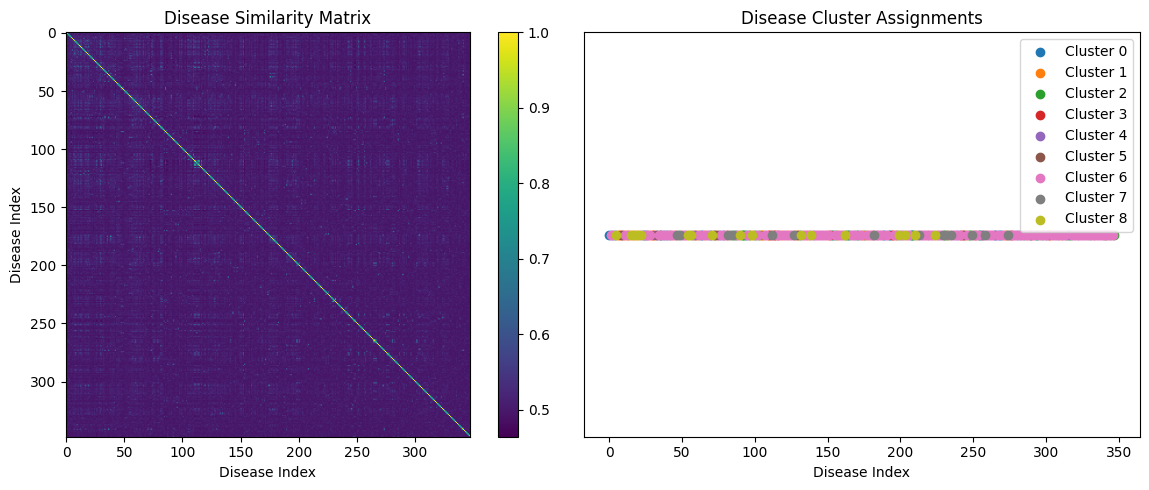

(array([0, 6, 4, 6, 0, 8, 1, 1, 3, 5, 1, 6, 1, 1, 6, 8, 1, 1, 8, 1, 8, 6,
        8, 0, 6, 0, 3, 6, 6, 1, 3, 1, 4, 5, 6, 0, 5, 6, 0, 6, 0, 6, 5, 6,
        6, 1, 6, 7, 7, 7, 6, 6, 6, 6, 8, 8, 8, 4, 1, 4, 1, 1, 6, 0, 4, 6,
        1, 6, 6, 0, 6, 8, 5, 5, 1, 4, 4, 6, 4, 4, 6, 1, 7, 6, 2, 7, 2, 2,
        6, 6, 8, 2, 2, 2, 0, 6, 2, 1, 8, 1, 2, 6, 6, 2, 1, 1, 1, 6, 6, 1,
        3, 3, 7, 3, 3, 6, 3, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 7, 1, 5, 1, 0,
        8, 6, 6, 6, 1, 6, 6, 8, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 3, 2,
        0, 6, 2, 1, 6, 6, 6, 6, 8, 2, 0, 2, 6, 6, 4, 6, 2, 4, 6, 6, 1, 0,
        1, 6, 1, 6, 6, 3, 7, 6, 6, 6, 6, 6, 4, 0, 6, 6, 0, 0, 3, 1, 6, 1,
        4, 8, 4, 6, 6, 8, 6, 6, 6, 0, 0, 2, 8, 6, 6, 7, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 8, 6, 6, 6, 6, 7, 2, 7, 2, 1, 6, 7, 6, 6, 6, 4, 6, 6,
        3, 3, 5, 1, 6, 2, 2, 7, 6, 3, 6, 6, 2, 0, 3, 4, 7, 6, 6, 6, 6, 6,
        4, 4, 4, 6, 0, 0, 6, 6, 1, 5, 7, 3, 6, 3, 6, 6, 4, 6, 4, 6, 6, 2,
        6, 6, 6, 0, 3, 6, 6, 2, 0, 6, 

In [25]:
visualize_disease_clusters(Y_avg,10)